In [1]:
import random
import torch
from torch import nn
from torch.distributions.categorical import Categorical
from Levenshtein import distance
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Define the forward probability $P_F$

In [2]:
# Define chunk vocabulary examples
three_letter_chunks = ["AAA", "BBB", "CCC", "ACC", "BCA", "CCB", "AAB", "BBC", "CCA"]
six_letter_chunks = [
    "AAABBB",
    "BBACCC",
    "CCBAAA",
    "ACBBBC",
    "BACACC",
    "CBBAAA",
    "ABCABC",
    "BCACBC",
    "CACABC",
]
nine_letter_chunks = [
    "AAABBBCAC",
    "BBCACCCBB",
    "CCBBBAAAB",
    "ACBBBCBAA",
    "BACACACAC",
    "CBBAAAACA",
    "ABCBCBABA",
    "BCACABCCC",
    "CACABCBBB",
]

# Define rules for generating sentences (for now only if starts then can end with)
rules = [
    ("AAA", ["AAA", "CCC", "BBB", "AAC", "AAABBBCCC"]),
    ("BBB", ["BBB", "AAA", "CCC", "BCA", "CCBAAABBB"]),
    ("CCC", ["CCC", "BBB", "AAA", "ACC", "BBCAACCCC"]),
    ("ACC", ["CBB", "BBB", "CAC", "AAABBBCAC"]),
    ("BCA", ["CAC", "ABC", "BAC", "ACBBBCBAA"]),
    ("CCB", ["BBB", "ABC", "CCA", "ABCBCBABA"]),
]

# Generate a dataset of sentences
def generate_sentence(max_len=30):
    assert max_len % 3 == 0, "The maximum length should be a multiple of 3."
    assert max_len > 6, "The maximum length should be longer than 6."
    while True:
        start_chunk, end_chunks = random.choice(rules)
        middle_chunk = random.choice(six_letter_chunks + nine_letter_chunks)
        end_chunk = random.choice(end_chunks)
        sentence = start_chunk + middle_chunk + end_chunk
        if len(sentence) != max_len:
            # If the sentence length is not 30, modify the middle_chunk by adding 3-letter tokens
            required_length = max_len - len(sentence)
            if required_length <= 0:
                continue  # Skip this iteration if the middle_chunk is too long
            middle_chunk += "".join(
                random.choice(three_letter_chunks) for _ in range(required_length // 3)
            )
            sentence = start_chunk + middle_chunk + end_chunk
        return sentence
class ChunkDataset(Dataset):
    def __init__(self, max_len=30, num_sentences=1000):
        self.vocab2token = {k: i for i, k in enumerate(["A", "B", "C"])}
        self.token2vocab = {i: k for i, k in enumerate(["A", "B", "C"])}
        self.num_sentences = num_sentences
        self.data = [generate_sentence(max_len) for _ in range(num_sentences)]

    def __len__(self):
        return self.num_sentences

    def __getitem__(self, i):
        vec = torch.tensor([self.vocab2token[k] for k in self.data[i]])
        out = torch.zeros((len(vec), len(self.vocab2token)))
        out[range(len(vec)), vec] = 1
        return out

In [3]:
class MLP(nn.Module):
    def __init__(self, num_layers, hidden_dim, vocab_size, act):
        super(MLP, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Linear(vocab_size, hidden_dim)
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2*hidden_dim, hidden_dim))
        self.layers.append(act)
        for _ in range(self.num_layers):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(act)
        self.layers.append(nn.Linear(hidden_dim, vocab_size))
        
        self.logZ = nn.Parameter(torch.ones(1))
    
    def forward(self, x, state):
        """
        Args:
            x [B, N, dim]
            state [B, M, dim]
        """
        x_ = self.embedding(x).mean(1)
        s = self.embedding(state).mean(1)
        
        out = torch.cat([x_, s], dim=-1)
        for layer in self.layers:
            out = layer(out)
        return out

In [4]:
class RNN(nn.Module):
    def __init__(self, num_layers, hidden_dim, vocab_size, act):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Linear(vocab_size, hidden_dim)
        
        self.rnn_encoder = nn.GRU(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(act)
        for _ in range(self.num_layers):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(act)
        self.layers.append(nn.Linear(hidden_dim, vocab_size))
        
        self.pool = nn.Linear(vocab_size, 1)
            
    def forward(self, x, state):
        """
        Args:
            x [B, N, dim]
            state [B, M, dim]
        """
        
        x__, x_ = self.rnn_encoder(self.embedding(x))
        s, _ = self.rnn_encoder(self.embedding(state), x_)
        out = s[:,-1]
        logZ = x__[:,-1]
        for layer in self.layers:
            out = layer(out)
            logZ = layer(logZ)
        logZ = self.pool(logZ)
        return out, logZ

In [12]:
class Vocabulary:
    def __init__(self, vocab):
        self.vocab = vocab
        
    def s2v(self, sample):
        if sample == "":
            return np.zeros((1,len(self.vocab)))
        indices = [self.vocab.index(element) for element in sample]
        vec = np.zeros((len(sample), len(self.vocab)))
        vec[range(len(sample)),indices] = 1
        return vec
    
    def __len__(self):
        return len(self.vocab)
    
    def v2s(self, vec):
        indices = np.argmax(vec, axis=-1)
        return "".join([self.vocab[i] for i in indices])

In [16]:
vocab = Vocabulary(["A", "B", "C"])
batch_size = 32
# Generate a dataset with a specified number of sentences
num_sentences = 1000
max_len = 12
dataset = ChunkDataset(max_len, 1000)
dataloader = DataLoader(dataset, batch_size=batch_size)
P_F = RNN(1, 128, 3, nn.ReLU()).cuda()
opt = torch.optim.Adam(P_F.parameters(),  3e-4)
max_states = len(vocab)**max_len

In [17]:
tb_losses = []
logZs = []
sampled_states = set()
logrewards = []
coverage = []

In [24]:
for epoch in tqdm(range(500)):
    for batch in dataloader:
        x = batch.cuda().float()
        state = torch.from_numpy(vocab.s2v("")).float().unsqueeze(0).cuda().repeat(x.shape[0], 1, 1)
        p_f_s, logZ = P_F(x, state)
        log_pf = 0
        log_pb = 0
        for t in range(max_len):
            cat = Categorical(logits=p_f_s)
            act = cat.sample()
            action = torch.zeros((x.shape[0], len(vocab))).float().cuda()
            action.scatter_(-1, act.unsqueeze(-1), 1)
            action = action.unsqueeze(1)
            log_pf += cat.log_prob(act)
            if t==0:
                new_state = action
            else:
                new_state = torch.cat([state, action], dim=1)
            p_f_s, logZ = P_F(x, new_state)
            state = new_state
        logreward = -((x-state).pow(2)).sum((1,2))
        loss = (logZ+log_pf-logreward-log_pb).pow(2).mean()
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        tb_losses.append(loss.item())
        logZs.append(logZ.mean().item())
        logrewards.append(logreward.mean().item())
        sampled_states.union(set([vocab.v2s(state[i].detach().cpu().long()) for i in range(state.shape[0])]))
        coverage.append(len(set(sampled_states))/max_states)
    
        
        print("loss:", loss.item(), "logreward:", logreward.mean().item(), "logZ:", logZ.mean().item())

  0%|          | 0/500 [00:00<?, ?it/s]

loss: 0.7576296925544739 logreward: -6.625 logZ: 2.389955520629883
loss: 1.0050736665725708 logreward: -6.0 logZ: 2.3652820587158203
loss: 1.2230010032653809 logreward: -5.6875 logZ: 2.3871283531188965
loss: 2.906327247619629 logreward: -6.0 logZ: 2.372399091720581
loss: 2.2053537368774414 logreward: -6.6875 logZ: 2.3787009716033936
loss: 1.8385138511657715 logreward: -5.125 logZ: 2.3877315521240234
loss: 0.8248754143714905 logreward: -5.4375 logZ: 2.3872790336608887
loss: 1.0287284851074219 logreward: -4.875 logZ: 2.3456993103027344
loss: 1.262601613998413 logreward: -5.1875 logZ: 2.3479349613189697
loss: 0.8579867482185364 logreward: -4.8125 logZ: 2.34049654006958
loss: 1.169374942779541 logreward: -5.5 logZ: 2.3380870819091797
loss: 0.9777086973190308 logreward: -4.4375 logZ: 2.3385167121887207
loss: 1.3820159435272217 logreward: -6.0 logZ: 2.36818265914917
loss: 0.8350800275802612 logreward: -5.5625 logZ: 2.3702006340026855
loss: 1.5755373239517212 logreward: -5.8125 logZ: 2.354538

loss: 2.3282113075256348 logreward: -7.0 logZ: 2.424116849899292
loss: 1.5212385654449463 logreward: -7.0625 logZ: 2.4335532188415527
loss: 0.9937704801559448 logreward: -5.5625 logZ: 2.4104318618774414
loss: 0.9923180341720581 logreward: -5.375 logZ: 2.4335131645202637
loss: 0.27341949939727783 logreward: -5.75 logZ: 2.4735584259033203
loss: 0.9343336820602417 logreward: -5.1875 logZ: 2.418769359588623
loss: 0.991944432258606 logreward: -5.875 logZ: 2.3937740325927734
loss: 2.1531577110290527 logreward: -6.5625 logZ: 2.4232254028320312
loss: 2.827937602996826 logreward: -6.875 logZ: 2.3990302085876465
loss: 0.8868144750595093 logreward: -5.8125 logZ: 2.3879318237304688
loss: 1.539816975593567 logreward: -5.375 logZ: 2.4134116172790527
loss: 0.5703079700469971 logreward: -6.375 logZ: 2.4554266929626465
loss: 0.962371289730072 logreward: -5.5625 logZ: 2.431988477706909
loss: 2.9657278060913086 logreward: -6.5625 logZ: 2.4402198791503906
loss: 0.8614301681518555 logreward: -5.1875 logZ: 

loss: 1.3457164764404297 logreward: -5.75 logZ: 2.492030143737793
loss: 0.45233646035194397 logreward: -5.375 logZ: 2.482696056365967
loss: 1.5654947757720947 logreward: -5.5 logZ: 2.4796009063720703
loss: 0.9460086226463318 logreward: -5.125 logZ: 2.4748806953430176
loss: 1.3077396154403687 logreward: -5.75 logZ: 2.4674253463745117
loss: 1.792206883430481 logreward: -5.75 logZ: 2.4283626079559326
loss: 1.442194938659668 logreward: -6.0625 logZ: 2.428891181945801
loss: 1.5137991905212402 logreward: -6.5 logZ: 2.411846876144409
loss: 1.2578413486480713 logreward: -6.0 logZ: 2.4264702796936035
loss: 0.3618481159210205 logreward: -4.0 logZ: 2.46110200881958
loss: 1.107854962348938 logreward: -5.0625 logZ: 2.4089536666870117
loss: 1.6427347660064697 logreward: -6.3125 logZ: 2.3838932514190674
loss: 2.8089237213134766 logreward: -6.0 logZ: 2.4109723567962646
loss: 0.7787859439849854 logreward: -5.8125 logZ: 2.3898892402648926
loss: 1.1813573837280273 logreward: -5.625 logZ: 2.40079927444458

loss: 0.7190722227096558 logreward: -4.875 logZ: 2.5892324447631836
loss: 0.625893235206604 logreward: -5.0625 logZ: 2.571927309036255
loss: 1.128691554069519 logreward: -6.0625 logZ: 2.5902280807495117
loss: 0.473323792219162 logreward: -4.6875 logZ: 2.587383985519409
loss: 0.32436808943748474 logreward: -5.0625 logZ: 2.573336124420166
loss: 0.8193888664245605 logreward: -5.0625 logZ: 2.5495991706848145
loss: 0.8109745979309082 logreward: -5.8125 logZ: 2.5730719566345215
loss: 0.7010630369186401 logreward: -6.0 logZ: 2.5445194244384766
loss: 0.5765211582183838 logreward: -4.5 logZ: 2.537066698074341
loss: 0.312709242105484 logreward: -4.625 logZ: 2.5329253673553467
loss: 1.0002979040145874 logreward: -5.9375 logZ: 2.5002663135528564
loss: 1.0944178104400635 logreward: -6.0 logZ: 2.521176338195801
loss: 0.8191899061203003 logreward: -4.8125 logZ: 2.5096607208251953
loss: 1.3676340579986572 logreward: -5.8125 logZ: 2.5277509689331055
loss: 0.2737332582473755 logreward: -5.5 logZ: 2.5566

loss: 0.4624796211719513 logreward: -6.0 logZ: 2.5721893310546875
loss: 0.839855968952179 logreward: -5.375 logZ: 2.585476875305176
loss: 0.7902368307113647 logreward: -5.25 logZ: 2.583343982696533
loss: 0.7116110324859619 logreward: -6.0 logZ: 2.5994625091552734
loss: 1.6413754224777222 logreward: -5.75 logZ: 2.592545509338379
loss: 0.8504948019981384 logreward: -5.6875 logZ: 2.5941452980041504
loss: 0.880014181137085 logreward: -4.25 logZ: 2.58852481842041
loss: 0.9495856761932373 logreward: -6.0625 logZ: 2.5972495079040527
loss: 0.6221657395362854 logreward: -5.5625 logZ: 2.612842321395874
loss: 0.5927355885505676 logreward: -5.25 logZ: 2.5990030765533447
loss: 0.5517958402633667 logreward: -5.75 logZ: 2.596989393234253
loss: 0.4092913269996643 logreward: -4.375 logZ: 2.601308822631836
loss: 0.9524702429771423 logreward: -5.1875 logZ: 2.5860307216644287
loss: 1.2901082038879395 logreward: -6.4375 logZ: 2.5842413902282715
loss: 1.1492533683776855 logreward: -6.125 logZ: 2.58154201507

loss: 0.7813399434089661 logreward: -5.75 logZ: 2.5692124366760254
loss: 0.7168248891830444 logreward: -6.6875 logZ: 2.5885300636291504
loss: 0.6430931687355042 logreward: -5.625 logZ: 2.575711250305176
loss: 0.6630373001098633 logreward: -5.875 logZ: 2.5635664463043213
loss: 0.49098271131515503 logreward: -5.1875 logZ: 2.5826194286346436
loss: 1.1807069778442383 logreward: -6.1875 logZ: 2.5838513374328613
loss: 0.6457043886184692 logreward: -5.3125 logZ: 2.5984745025634766
loss: 0.36857903003692627 logreward: -5.0 logZ: 2.61104679107666
loss: 0.7503229379653931 logreward: -4.9375 logZ: 2.6137914657592773
loss: 1.5137503147125244 logreward: -5.5625 logZ: 2.604832172393799
loss: 0.909574568271637 logreward: -6.5625 logZ: 2.606950521469116
loss: 0.9555996060371399 logreward: -6.125 logZ: 2.612201452255249
loss: 0.9820481538772583 logreward: -6.0 logZ: 2.6318397521972656
loss: 0.6291791200637817 logreward: -5.875 logZ: 2.6283791065216064
loss: 0.5281156897544861 logreward: -6.5 logZ: 2.62

loss: 0.5452260971069336 logreward: -6.1875 logZ: 2.6251220703125
loss: 0.8847472667694092 logreward: -5.375 logZ: 2.6056339740753174
loss: 1.2571619749069214 logreward: -5.5625 logZ: 2.623969078063965
loss: 0.6645493507385254 logreward: -5.375 logZ: 2.6395673751831055
loss: 0.47910016775131226 logreward: -5.0625 logZ: 2.655032157897949
loss: 0.7509925961494446 logreward: -5.6875 logZ: 2.638576030731201
loss: 0.33812814950942993 logreward: -5.1875 logZ: 2.6606626510620117
loss: 0.5060130953788757 logreward: -5.5625 logZ: 2.6554269790649414
loss: 0.7014355659484863 logreward: -5.75 logZ: 2.635730743408203
loss: 0.4070989191532135 logreward: -4.625 logZ: 2.664257049560547
loss: 1.1446154117584229 logreward: -6.6875 logZ: 2.6621713638305664
loss: 0.5893288850784302 logreward: -5.25 logZ: 2.6742310523986816
loss: 0.8962689638137817 logreward: -5.5 logZ: 2.6596126556396484
loss: 0.41537606716156006 logreward: -5.375 logZ: 2.6677212715148926
loss: 0.8437824249267578 logreward: -5.75 logZ: 2.

loss: 0.44640082120895386 logreward: -5.5 logZ: 2.6115031242370605
loss: 0.6698817014694214 logreward: -5.875 logZ: 2.627094030380249
loss: 0.1675330102443695 logreward: -6.5 logZ: 2.6658573150634766
loss: 0.3334490656852722 logreward: -4.9375 logZ: 2.6252894401550293
loss: 0.3173275589942932 logreward: -5.0 logZ: 2.6110591888427734
loss: 0.23935651779174805 logreward: -5.1875 logZ: 2.6331915855407715
loss: 0.2793974280357361 logreward: -5.375 logZ: 2.6132137775421143
loss: 0.7767409682273865 logreward: -5.8125 logZ: 2.6195170879364014
loss: 0.4006813168525696 logreward: -5.6875 logZ: 2.63386869430542
loss: 0.30237293243408203 logreward: -5.9375 logZ: 2.6501734256744385
loss: 0.2826439142227173 logreward: -5.3125 logZ: 2.6265041828155518
loss: 0.15088987350463867 logreward: -4.625 logZ: 2.6400070190429688
loss: 0.7504974007606506 logreward: -5.375 logZ: 2.6335484981536865
loss: 0.7405562996864319 logreward: -6.125 logZ: 2.610117197036743
loss: 0.5169875621795654 logreward: -4.875 logZ:

loss: 0.2947610914707184 logreward: -5.0625 logZ: 2.666534900665283
loss: 0.4837937653064728 logreward: -4.75 logZ: 2.6628074645996094
loss: 1.1871281862258911 logreward: -5.9375 logZ: 2.6772968769073486
loss: 0.45894140005111694 logreward: -5.3125 logZ: 2.647545576095581
loss: 0.5282514095306396 logreward: -5.25 logZ: 2.656558036804199
loss: 0.4411718547344208 logreward: -5.3125 logZ: 2.6544365882873535
loss: 0.3449832797050476 logreward: -5.4375 logZ: 2.676891326904297
loss: 0.19483768939971924 logreward: -6.0 logZ: 2.7257463932037354
loss: 0.5024089217185974 logreward: -4.8125 logZ: 2.687081813812256
loss: 0.37656253576278687 logreward: -4.75 logZ: 2.6744654178619385
loss: 0.4930993318557739 logreward: -5.4375 logZ: 2.6993231773376465
loss: 1.616761326789856 logreward: -6.125 logZ: 2.679933547973633
loss: 0.47712433338165283 logreward: -4.5 logZ: 2.6948344707489014
loss: 0.2885613441467285 logreward: -4.6875 logZ: 2.6937685012817383
loss: 0.24679137766361237 logreward: -4.625 logZ: 

loss: 0.3267626166343689 logreward: -5.5 logZ: 2.6872942447662354
loss: 0.48691099882125854 logreward: -5.0 logZ: 2.6888251304626465
loss: 0.5332804322242737 logreward: -6.0 logZ: 2.6787285804748535
loss: 0.6376579403877258 logreward: -4.6875 logZ: 2.688541889190674
loss: 0.34999755024909973 logreward: -5.5 logZ: 2.6947243213653564
loss: 0.6536181569099426 logreward: -4.5625 logZ: 2.7006783485412598
loss: 0.5189484357833862 logreward: -6.3125 logZ: 2.679974317550659
loss: 0.8093240261077881 logreward: -5.375 logZ: 2.684366226196289
loss: 0.27971142530441284 logreward: -5.8125 logZ: 2.65073299407959
loss: 0.30442678928375244 logreward: -5.0625 logZ: 2.6533870697021484
loss: 0.4539811313152313 logreward: -4.625 logZ: 2.6224522590637207
loss: 0.2814893126487732 logreward: -5.9375 logZ: 2.632007598876953
loss: 0.37243226170539856 logreward: -4.5 logZ: 2.6531996726989746
loss: 0.34412866830825806 logreward: -5.3125 logZ: 2.62538480758667
loss: 0.3056378960609436 logreward: -5.5 logZ: 2.6096

loss: 0.24750003218650818 logreward: -5.1875 logZ: 2.7263879776000977
loss: 0.7168861627578735 logreward: -5.8125 logZ: 2.7465972900390625
loss: 0.35549014806747437 logreward: -5.375 logZ: 2.7274646759033203
loss: 0.35626864433288574 logreward: -5.0 logZ: 2.7359585762023926
loss: 0.3804798126220703 logreward: -6.5 logZ: 2.722583293914795
loss: 0.24239259958267212 logreward: -4.75 logZ: 2.730623960494995
loss: 0.4379104971885681 logreward: -5.4375 logZ: 2.7350502014160156
loss: 0.15867559611797333 logreward: -5.5625 logZ: 2.713649272918701
loss: 0.2381111979484558 logreward: -4.6875 logZ: 2.733572244644165
loss: 0.23279735445976257 logreward: -5.3125 logZ: 2.723029136657715
loss: 0.28938955068588257 logreward: -5.25 logZ: 2.730806350708008
loss: 0.5910632610321045 logreward: -5.6875 logZ: 2.7294540405273438
loss: 0.40731751918792725 logreward: -5.1875 logZ: 2.743784189224243
loss: 0.45674943923950195 logreward: -5.0 logZ: 2.719964027404785
loss: 0.35551804304122925 logreward: -4.5 logZ:

loss: 0.2666814625263214 logreward: -5.6875 logZ: 2.686516761779785
loss: 0.2873981297016144 logreward: -5.6875 logZ: 2.678373336791992
loss: 0.42345988750457764 logreward: -5.5625 logZ: 2.6949563026428223
loss: 0.47536471486091614 logreward: -5.125 logZ: 2.672321319580078
loss: 0.3541979193687439 logreward: -5.1875 logZ: 2.6979336738586426
loss: 0.200091153383255 logreward: -5.5625 logZ: 2.690502166748047
loss: 0.3492797911167145 logreward: -5.375 logZ: 2.7050437927246094
loss: 0.6476152539253235 logreward: -5.9375 logZ: 2.701180934906006
loss: 0.33904772996902466 logreward: -4.625 logZ: 2.7059011459350586
loss: 0.30298537015914917 logreward: -6.0 logZ: 2.697070837020874
loss: 0.22084420919418335 logreward: -5.6875 logZ: 2.7121942043304443
loss: 0.26080605387687683 logreward: -5.8125 logZ: 2.7280168533325195
loss: 0.24410337209701538 logreward: -5.6875 logZ: 2.722764015197754
loss: 0.2697994112968445 logreward: -4.4375 logZ: 2.738234043121338
loss: 0.174472838640213 logreward: -5.1875

loss: 0.3773919939994812 logreward: -5.1875 logZ: 2.784735679626465
loss: 0.42454493045806885 logreward: -5.9375 logZ: 2.7812445163726807
loss: 0.34405437111854553 logreward: -4.6875 logZ: 2.7718400955200195
loss: 0.24821746349334717 logreward: -6.0625 logZ: 2.76101016998291
loss: 0.10886625200510025 logreward: -5.0625 logZ: 2.763498306274414
loss: 0.4704325795173645 logreward: -5.0 logZ: 2.752392530441284
loss: 0.3377061188220978 logreward: -5.0 logZ: 2.7310452461242676
loss: 0.12001027166843414 logreward: -6.0625 logZ: 2.752976894378662
loss: 0.26666221022605896 logreward: -5.0625 logZ: 2.7412819862365723
loss: 0.19567814469337463 logreward: -6.0 logZ: 2.7512505054473877
loss: 0.15101027488708496 logreward: -4.875 logZ: 2.7347447872161865
loss: 0.2055503875017166 logreward: -5.0625 logZ: 2.7545580863952637
loss: 0.2762097716331482 logreward: -5.75 logZ: 2.74324369430542
loss: 0.1779022216796875 logreward: -5.5 logZ: 2.753190517425537
loss: 0.45904797315597534 logreward: -4.375 logZ: 

loss: 0.06316740810871124 logreward: -5.25 logZ: 2.7828288078308105
loss: 0.23177054524421692 logreward: -4.1875 logZ: 2.759212017059326
loss: 0.3679502010345459 logreward: -5.5 logZ: 2.7436413764953613
loss: 1.0754907131195068 logreward: -6.25 logZ: 2.751612901687622
loss: 0.21672983467578888 logreward: -4.3125 logZ: 2.7539350986480713
loss: 0.40959227085113525 logreward: -4.9375 logZ: 2.785642385482788
loss: 0.389880895614624 logreward: -5.4375 logZ: 2.7852888107299805
loss: 0.4171561002731323 logreward: -4.875 logZ: 2.7536802291870117
loss: 0.28117597103118896 logreward: -4.6875 logZ: 2.747190475463867
loss: 0.1872013509273529 logreward: -6.375 logZ: 2.7419309616088867
loss: 0.2831340432167053 logreward: -5.375 logZ: 2.743286371231079
loss: 0.45218175649642944 logreward: -5.875 logZ: 2.749462127685547
loss: 0.2602875232696533 logreward: -4.625 logZ: 2.741753578186035
loss: 0.5944318175315857 logreward: -5.3125 logZ: 2.7487096786499023
loss: 0.22000908851623535 logreward: -5.25 logZ:

loss: 0.3061949610710144 logreward: -4.875 logZ: 2.830477714538574
loss: 0.3109648823738098 logreward: -5.5625 logZ: 2.807286500930786
loss: 0.19769559800624847 logreward: -5.3125 logZ: 2.8183093070983887
loss: 0.17946380376815796 logreward: -5.4375 logZ: 2.800983428955078
loss: 0.1612149477005005 logreward: -4.8125 logZ: 2.8026175498962402
loss: 0.028324710205197334 logreward: -5.25 logZ: 2.8162007331848145
loss: 0.38569775223731995 logreward: -4.875 logZ: 2.808563232421875
loss: 0.1614827811717987 logreward: -4.9375 logZ: 2.797224998474121
loss: 0.22838479280471802 logreward: -4.875 logZ: 2.811276912689209
loss: 0.355194091796875 logreward: -5.1875 logZ: 2.797488212585449
loss: 0.1917991191148758 logreward: -5.0625 logZ: 2.804370403289795
loss: 0.6885538697242737 logreward: -5.75 logZ: 2.8053619861602783
loss: 0.29355183243751526 logreward: -5.375 logZ: 2.8027219772338867
loss: 0.2029949426651001 logreward: -5.5625 logZ: 2.7825117111206055
loss: 0.0953277125954628 logreward: -4.875 l

loss: 0.15847459435462952 logreward: -5.25 logZ: 2.7764689922332764
loss: 0.2147209644317627 logreward: -4.9375 logZ: 2.7862930297851562
loss: 0.13375863432884216 logreward: -5.6875 logZ: 2.786531686782837
loss: 0.19845335185527802 logreward: -5.0 logZ: 2.7946321964263916
loss: 0.14977674186229706 logreward: -5.0 logZ: 2.7919979095458984
loss: 0.18130004405975342 logreward: -5.1875 logZ: 2.816932439804077
loss: 0.2197236716747284 logreward: -5.125 logZ: 2.808999538421631
loss: 0.6046584248542786 logreward: -6.125 logZ: 2.8230173587799072
loss: 0.1115996241569519 logreward: -4.5625 logZ: 2.8273890018463135
loss: 0.12204080820083618 logreward: -4.875 logZ: 2.8228373527526855
loss: 0.05934290587902069 logreward: -3.75 logZ: 2.862536907196045
loss: 0.26378217339515686 logreward: -5.1875 logZ: 2.8345367908477783
loss: 0.33797353506088257 logreward: -5.9375 logZ: 2.8185811042785645
loss: 0.046074848622083664 logreward: -4.0 logZ: 2.8365840911865234
loss: 0.21760019659996033 logreward: -4.937

loss: 0.12764009833335876 logreward: -4.5 logZ: 2.8050403594970703
loss: 0.28566068410873413 logreward: -5.125 logZ: 2.7933268547058105
loss: 0.3145732283592224 logreward: -5.8125 logZ: 2.7985191345214844
loss: 0.20616009831428528 logreward: -4.8125 logZ: 2.7908830642700195
loss: 0.14026162028312683 logreward: -5.375 logZ: 2.795215368270874
loss: 0.2027415633201599 logreward: -5.1875 logZ: 2.7825441360473633
loss: 0.06524911522865295 logreward: -5.0 logZ: 2.7957634925842285
loss: 0.0890178456902504 logreward: -4.5625 logZ: 2.791402816772461
loss: 0.12971635162830353 logreward: -5.0 logZ: 2.7826735973358154
loss: 0.10413568466901779 logreward: -4.375 logZ: 2.783600330352783
loss: 0.19357717037200928 logreward: -5.1875 logZ: 2.792506694793701
loss: 0.1651601642370224 logreward: -4.9375 logZ: 2.7926900386810303
loss: 0.14551925659179688 logreward: -5.75 logZ: 2.7824625968933105
loss: 0.17302708327770233 logreward: -5.4375 logZ: 2.7927188873291016
loss: 0.2893659174442291 logreward: -6.312

loss: 0.1999044418334961 logreward: -4.625 logZ: 2.8301191329956055
loss: 0.36294418573379517 logreward: -4.8125 logZ: 2.8180766105651855
loss: 0.1692211627960205 logreward: -5.4375 logZ: 2.8055193424224854
loss: 0.14166170358657837 logreward: -5.625 logZ: 2.804220676422119
loss: 0.23241817951202393 logreward: -5.625 logZ: 2.7918167114257812
loss: 0.194410502910614 logreward: -6.1875 logZ: 2.7714929580688477
loss: 0.2730492949485779 logreward: -5.6875 logZ: 2.7808964252471924
loss: 0.16953904926776886 logreward: -4.9375 logZ: 2.7709238529205322
loss: 0.2523396611213684 logreward: -5.3125 logZ: 2.7738218307495117
loss: 0.09192941337823868 logreward: -5.0 logZ: 2.7536261081695557
loss: 0.10150568187236786 logreward: -4.9375 logZ: 2.7669222354888916
loss: 0.20104017853736877 logreward: -6.4375 logZ: 2.7599642276763916
loss: 0.18934409320354462 logreward: -5.5 logZ: 2.7610273361206055
loss: 0.1555277556180954 logreward: -5.25 logZ: 2.7562599182128906
loss: 0.09376708418130875 logreward: -5

loss: 0.29106438159942627 logreward: -6.625 logZ: 2.8034982681274414
loss: 0.3333355188369751 logreward: -5.0 logZ: 2.792769193649292
loss: 0.3463837206363678 logreward: -5.0625 logZ: 2.798715829849243
loss: 0.218378946185112 logreward: -5.0 logZ: 2.7781333923339844
loss: 0.11114276945590973 logreward: -4.25 logZ: 2.789212465286255
loss: 0.3239542245864868 logreward: -6.0625 logZ: 2.7919373512268066
loss: 0.05105298385024071 logreward: -3.625 logZ: 2.7915186882019043
loss: 0.16175568103790283 logreward: -4.6875 logZ: 2.781038284301758
loss: 0.05014755204319954 logreward: -5.5625 logZ: 2.7909350395202637
loss: 0.17592282593250275 logreward: -5.0625 logZ: 2.7957100868225098
loss: 0.17246472835540771 logreward: -4.1875 logZ: 2.789391279220581
loss: 0.16312405467033386 logreward: -4.4375 logZ: 2.7920479774475098
loss: 0.16397616267204285 logreward: -4.5 logZ: 2.7916717529296875
loss: 0.14054737985134125 logreward: -4.875 logZ: 2.796015739440918
loss: 0.09270204603672028 logreward: -5.5 log

loss: 0.19050991535186768 logreward: -4.9375 logZ: 2.793294906616211
loss: 0.255660742521286 logreward: -5.0625 logZ: 2.7828564643859863
loss: 0.10547161102294922 logreward: -5.0625 logZ: 2.796675682067871
loss: 0.27627983689308167 logreward: -4.9375 logZ: 2.783388376235962
loss: 0.22408723831176758 logreward: -5.375 logZ: 2.7928242683410645
loss: 0.08599565923213959 logreward: -5.5625 logZ: 2.789630651473999
loss: 0.11413176357746124 logreward: -4.625 logZ: 2.7954697608947754
loss: 0.008395973592996597 logreward: -4.5 logZ: 2.8212435245513916
loss: 0.1652834117412567 logreward: -4.8125 logZ: 2.801513195037842
loss: 0.135354146361351 logreward: -5.1875 logZ: 2.7916946411132812
loss: 0.1311596930027008 logreward: -3.875 logZ: 2.801344871520996
loss: 0.19708426296710968 logreward: -4.875 logZ: 2.795217275619507
loss: 0.13268020749092102 logreward: -5.0 logZ: 2.8046932220458984
loss: 0.15472066402435303 logreward: -4.4375 logZ: 2.8131375312805176
loss: 0.19717898964881897 logreward: -5.56

loss: 0.1687527298927307 logreward: -6.1875 logZ: 2.834440231323242
loss: 0.16005980968475342 logreward: -5.25 logZ: 2.8392586708068848
loss: 0.09061023592948914 logreward: -6.125 logZ: 2.833444595336914
loss: 0.06632271409034729 logreward: -5.625 logZ: 2.8366150856018066
loss: 0.07242496311664581 logreward: -4.6875 logZ: 2.83729887008667
loss: 0.08803565800189972 logreward: -5.25 logZ: 2.8296985626220703
loss: 0.15985585749149323 logreward: -4.5 logZ: 2.827895164489746
loss: 0.056322403252124786 logreward: -5.3125 logZ: 2.830624580383301
loss: 0.18381313979625702 logreward: -5.0 logZ: 2.8394525051116943
loss: 0.19911061227321625 logreward: -4.875 logZ: 2.824575424194336
loss: 0.22748379409313202 logreward: -5.3125 logZ: 2.8400235176086426
loss: 0.09669652581214905 logreward: -4.625 logZ: 2.820491313934326
loss: 0.16484864056110382 logreward: -5.25 logZ: 2.822421073913574
loss: 0.08832770586013794 logreward: -5.5 logZ: 2.8085362911224365
loss: 0.12388121336698532 logreward: -5.4375 log

loss: 0.06427038460969925 logreward: -4.5 logZ: 2.7950758934020996
loss: 0.1705402135848999 logreward: -5.5 logZ: 2.7949116230010986
loss: 0.11404748260974884 logreward: -5.125 logZ: 2.792375326156616
loss: 0.15097755193710327 logreward: -6.3125 logZ: 2.8056819438934326
loss: 0.22847019135951996 logreward: -4.4375 logZ: 2.8154735565185547
loss: 0.10312578082084656 logreward: -4.9375 logZ: 2.818124294281006
loss: 0.06299559772014618 logreward: -5.0625 logZ: 2.815056562423706
loss: 0.13316631317138672 logreward: -5.1875 logZ: 2.819408655166626
loss: 0.1352902054786682 logreward: -5.3125 logZ: 2.819270372390747
loss: 0.11977913975715637 logreward: -4.75 logZ: 2.827735424041748
loss: 0.1258912980556488 logreward: -6.125 logZ: 2.8203868865966797
loss: 0.09527480602264404 logreward: -5.25 logZ: 2.8282949924468994
loss: 0.1201043576002121 logreward: -5.1875 logZ: 2.8328332901000977
loss: 0.03969135135412216 logreward: -4.625 logZ: 2.825482130050659
loss: 0.10372898727655411 logreward: -5.375 

loss: 0.24707528948783875 logreward: -5.5625 logZ: 2.8252081871032715
loss: 0.18494302034378052 logreward: -4.4375 logZ: 2.8174166679382324
loss: 0.05057888850569725 logreward: -4.9375 logZ: 2.824089765548706
loss: 0.21331214904785156 logreward: -5.4375 logZ: 2.8146722316741943
loss: 0.2244766652584076 logreward: -5.0625 logZ: 2.8268566131591797
loss: 0.18853342533111572 logreward: -5.0625 logZ: 2.8279881477355957
loss: 0.18090686202049255 logreward: -4.6875 logZ: 2.816425323486328
loss: 0.10959003865718842 logreward: -4.9375 logZ: 2.8173398971557617
loss: 0.07361648976802826 logreward: -5.5 logZ: 2.8154163360595703
loss: 0.15411846339702606 logreward: -5.875 logZ: 2.81479811668396
loss: 0.06913625448942184 logreward: -4.75 logZ: 2.7974514961242676
loss: 0.06270331889390945 logreward: -5.25 logZ: 2.807279586791992
loss: 0.27667495608329773 logreward: -5.3125 logZ: 2.805098533630371
loss: 0.07511205971240997 logreward: -5.25 logZ: 2.8094053268432617
loss: 0.058263517916202545 logreward:

loss: 0.17847840487957 logreward: -4.5625 logZ: 2.8194899559020996
loss: 0.11608726531267166 logreward: -4.75 logZ: 2.8172476291656494
loss: 0.2137555181980133 logreward: -5.625 logZ: 2.838082790374756
loss: 0.1228666603565216 logreward: -5.3125 logZ: 2.817422866821289
loss: 0.0316910482943058 logreward: -7.0 logZ: 2.8344669342041016
loss: 0.23499828577041626 logreward: -5.5625 logZ: 2.814401388168335
loss: 0.1269993782043457 logreward: -5.1875 logZ: 2.800942897796631
loss: 0.15628331899642944 logreward: -5.125 logZ: 2.8035354614257812
loss: 0.061981040984392166 logreward: -4.5625 logZ: 2.786761999130249
loss: 0.2847751975059509 logreward: -5.0 logZ: 2.799828052520752
loss: 0.2438255250453949 logreward: -5.1875 logZ: 2.8017821311950684
loss: 0.10033151507377625 logreward: -5.3125 logZ: 2.787742853164673
loss: 0.1651442050933838 logreward: -4.6875 logZ: 2.7845311164855957
loss: 0.08646581321954727 logreward: -5.125 logZ: 2.780172824859619
loss: 0.18469366431236267 logreward: -5.3125 log

loss: 0.049731478095054626 logreward: -4.5 logZ: 2.784506320953369
loss: 0.05361955612897873 logreward: -5.125 logZ: 2.79060697555542
loss: 0.08978230506181717 logreward: -5.25 logZ: 2.7770724296569824
loss: 0.02993883565068245 logreward: -4.875 logZ: 2.793896198272705
loss: 0.07342877984046936 logreward: -4.8125 logZ: 2.785215377807617
loss: 0.11321937292814255 logreward: -5.8125 logZ: 2.791602373123169
loss: 0.10626636445522308 logreward: -4.375 logZ: 2.790855884552002
loss: 0.16494983434677124 logreward: -5.3125 logZ: 2.819596767425537
loss: 0.14117231965065002 logreward: -4.8125 logZ: 2.820767402648926
loss: 0.07679784297943115 logreward: -4.3125 logZ: 2.8244810104370117
loss: 0.04152560979127884 logreward: -4.4375 logZ: 2.835590124130249
loss: 0.06772373616695404 logreward: -5.625 logZ: 2.8383588790893555
loss: 0.020589500665664673 logreward: -4.25 logZ: 2.857463836669922
loss: 0.16678175330162048 logreward: -5.8125 logZ: 2.85957670211792
loss: 0.06659160554409027 logreward: -4.25

loss: 0.06204158812761307 logreward: -5.25 logZ: 2.7771425247192383
loss: 0.1571633368730545 logreward: -6.0625 logZ: 2.766455888748169
loss: 0.07323351502418518 logreward: -5.3125 logZ: 2.785871982574463
loss: 0.4386614263057709 logreward: -5.6875 logZ: 2.7881217002868652
loss: 0.10846437513828278 logreward: -4.875 logZ: 2.7885360717773438
loss: 0.13146564364433289 logreward: -6.0 logZ: 2.7920522689819336
loss: 0.08702841401100159 logreward: -4.5 logZ: 2.7915139198303223
loss: 0.06190521642565727 logreward: -5.4375 logZ: 2.7973580360412598
loss: 0.14378243684768677 logreward: -5.3125 logZ: 2.7988905906677246
loss: 0.04802854359149933 logreward: -5.3125 logZ: 2.8079543113708496
loss: 0.06824614107608795 logreward: -6.3125 logZ: 2.810847759246826
loss: 0.086652010679245 logreward: -5.875 logZ: 2.8139591217041016
loss: 0.11479123681783676 logreward: -5.4375 logZ: 2.8100008964538574
loss: 0.14471188187599182 logreward: -5.3125 logZ: 2.8137738704681396
loss: 0.07052302360534668 logreward: 

loss: 0.12878404557704926 logreward: -4.875 logZ: 2.820268154144287
loss: 0.07543578743934631 logreward: -4.25 logZ: 2.8224539756774902
loss: 0.04855386167764664 logreward: -5.9375 logZ: 2.8252065181732178
loss: 0.03177876025438309 logreward: -4.5 logZ: 2.8307504653930664
loss: 0.0704585611820221 logreward: -5.5625 logZ: 2.826569080352783
loss: 0.11245857179164886 logreward: -4.9375 logZ: 2.8312501907348633
loss: 0.0405266210436821 logreward: -4.625 logZ: 2.8333072662353516
loss: 0.037168845534324646 logreward: -4.4375 logZ: 2.8270866870880127
loss: 0.08365058898925781 logreward: -5.5 logZ: 2.830599308013916
loss: 0.038507819175720215 logreward: -4.6875 logZ: 2.836414337158203
loss: 0.046996109187603 logreward: -5.6875 logZ: 2.845238208770752
loss: 0.04793345555663109 logreward: -5.0 logZ: 2.8509726524353027
loss: 0.05554157495498657 logreward: -5.5625 logZ: 2.8478734493255615
loss: 0.236731618642807 logreward: -5.6875 logZ: 2.8552703857421875
loss: 0.12906907498836517 logreward: -5.5 

loss: 0.05236370116472244 logreward: -4.4375 logZ: 2.8523130416870117
loss: 0.043842561542987823 logreward: -5.3125 logZ: 2.859333038330078
loss: 0.02591586485505104 logreward: -3.9375 logZ: 2.8573856353759766
loss: 0.04172121360898018 logreward: -5.0625 logZ: 2.8644933700561523
loss: 0.016293790191411972 logreward: -5.75 logZ: 2.876760244369507
loss: 0.06918846815824509 logreward: -5.5 logZ: 2.872378349304199
loss: 0.051468413323163986 logreward: -5.0625 logZ: 2.8748629093170166
loss: 0.07453462481498718 logreward: -5.5625 logZ: 2.8799405097961426
loss: 0.046554967761039734 logreward: -5.0 logZ: 2.8703348636627197
loss: 0.07061125338077545 logreward: -5.1875 logZ: 2.8713722229003906
loss: 0.031100042164325714 logreward: -4.3125 logZ: 2.869929075241089
loss: 0.09100213646888733 logreward: -5.625 logZ: 2.866816520690918
loss: 0.02759803831577301 logreward: -5.0625 logZ: 2.8581314086914062
loss: 0.022144649177789688 logreward: -3.875 logZ: 2.8554418087005615
loss: 0.06282199919223785 log

loss: 0.06528852880001068 logreward: -4.5625 logZ: 2.8574471473693848
loss: 0.046483155339956284 logreward: -5.1875 logZ: 2.859293222427368
loss: 0.04088830575346947 logreward: -5.9375 logZ: 2.866248846054077
loss: 0.034031942486763 logreward: -4.75 logZ: 2.872544527053833
loss: 0.026907261461019516 logreward: -4.5625 logZ: 2.8751754760742188
loss: 0.029168520122766495 logreward: -4.8125 logZ: 2.872684955596924
loss: 0.059821806848049164 logreward: -4.5 logZ: 2.876272678375244
loss: 0.08667586743831635 logreward: -5.5625 logZ: 2.885657787322998
loss: 0.0540284626185894 logreward: -5.0 logZ: 2.8844988346099854
loss: 0.051231205463409424 logreward: -4.875 logZ: 2.8852148056030273
loss: 0.05618389695882797 logreward: -5.125 logZ: 2.8923420906066895
loss: 0.0382823683321476 logreward: -4.9375 logZ: 2.885373592376709
loss: 0.016272468492388725 logreward: -5.0 logZ: 2.897700071334839
loss: 0.10005602985620499 logreward: -5.625 logZ: 2.881943941116333
loss: 0.05374303460121155 logreward: -5.3

loss: 0.04462888464331627 logreward: -4.5625 logZ: 2.860826015472412
loss: 0.034709103405475616 logreward: -5.5625 logZ: 2.8605432510375977
loss: 0.06623952090740204 logreward: -5.1875 logZ: 2.866530656814575
loss: 0.03834354504942894 logreward: -5.1875 logZ: 2.8627426624298096
loss: 0.07971146702766418 logreward: -5.125 logZ: 2.8580052852630615
loss: 0.04572940617799759 logreward: -4.5 logZ: 2.852952003479004
loss: 0.02797652781009674 logreward: -5.625 logZ: 2.8529696464538574
loss: 0.03779324144124985 logreward: -4.375 logZ: 2.8421478271484375
loss: 0.0329478420317173 logreward: -4.75 logZ: 2.8439278602600098
loss: 0.06184619665145874 logreward: -5.375 logZ: 2.843484878540039
loss: 0.05007904767990112 logreward: -5.9375 logZ: 2.835759401321411
loss: 0.040807634592056274 logreward: -5.375 logZ: 2.8335819244384766
loss: 0.05752261355519295 logreward: -6.375 logZ: 2.836580276489258
loss: 0.1187523901462555 logreward: -5.125 logZ: 2.8331313133239746
loss: 0.018301719799637794 logreward: 

loss: 0.03230844438076019 logreward: -5.1875 logZ: 2.872593402862549
loss: 0.043399009853601456 logreward: -4.6875 logZ: 2.8703041076660156
loss: 0.05227317661046982 logreward: -4.875 logZ: 2.874274253845215
loss: 0.054973892867565155 logreward: -4.75 logZ: 2.883253574371338
loss: 0.027575131505727768 logreward: -4.9375 logZ: 2.8792166709899902
loss: 0.032122183591127396 logreward: -4.75 logZ: 2.8791513442993164
loss: 0.02925148233771324 logreward: -5.8125 logZ: 2.8753607273101807
loss: 0.029696809127926826 logreward: -4.75 logZ: 2.869035243988037
loss: 0.01628202013671398 logreward: -4.375 logZ: 2.8736181259155273
loss: 0.04302559047937393 logreward: -5.75 logZ: 2.876753568649292
loss: 0.019035130739212036 logreward: -4.75 logZ: 2.8824970722198486
loss: 0.02575014904141426 logreward: -4.625 logZ: 2.879563331604004
loss: 0.034388672560453415 logreward: -4.875 logZ: 2.881199359893799
loss: 0.06602032482624054 logreward: -5.5625 logZ: 2.8791890144348145
loss: 0.03611356019973755 logrewar

loss: 0.06496982276439667 logreward: -4.9375 logZ: 2.8626766204833984
loss: 0.04949210584163666 logreward: -4.375 logZ: 2.8627443313598633
loss: 0.028344692662358284 logreward: -5.4375 logZ: 2.8615329265594482
loss: 0.049238547682762146 logreward: -6.25 logZ: 2.858952522277832
loss: 0.020383939146995544 logreward: -4.0 logZ: 2.8600940704345703
loss: 0.02872871793806553 logreward: -5.75 logZ: 2.8675143718719482
loss: 0.03222115337848663 logreward: -5.0625 logZ: 2.864966869354248
loss: 0.031299054622650146 logreward: -5.5625 logZ: 2.8657279014587402
loss: 0.01858101412653923 logreward: -5.25 logZ: 2.8628804683685303
loss: 0.048452943563461304 logreward: -5.5625 logZ: 2.8718771934509277
loss: 0.04918162152171135 logreward: -6.125 logZ: 2.871481418609619
loss: 0.061250027269124985 logreward: -4.5 logZ: 2.8649420738220215
loss: 0.03400222212076187 logreward: -5.3125 logZ: 2.8631489276885986
loss: 0.022487971931695938 logreward: -4.625 logZ: 2.8583288192749023
loss: 0.05902107059955597 logre

loss: 0.017721867188811302 logreward: -5.3125 logZ: 2.846151351928711
loss: 0.01687058061361313 logreward: -4.8125 logZ: 2.8503940105438232
loss: 0.03153068199753761 logreward: -5.0625 logZ: 2.8454976081848145
loss: 0.03517482057213783 logreward: -5.6875 logZ: 2.8460397720336914
loss: 0.021953262388706207 logreward: -5.375 logZ: 2.84260892868042
loss: 0.04049697890877724 logreward: -5.6875 logZ: 2.8482871055603027
loss: 0.04695805907249451 logreward: -6.25 logZ: 2.831008195877075
loss: 0.049539390951395035 logreward: -4.75 logZ: 2.8477253913879395
loss: 0.02937242202460766 logreward: -4.5625 logZ: 2.8538732528686523
loss: 0.08069786429405212 logreward: -5.6875 logZ: 2.852450370788574
loss: 0.023420993238687515 logreward: -4.8125 logZ: 2.858194351196289
loss: 0.02070491947233677 logreward: -4.125 logZ: 2.8627655506134033
loss: 0.018114235252141953 logreward: -6.25 logZ: 2.8770318031311035
loss: 0.055588241666555405 logreward: -5.75 logZ: 2.863182544708252
loss: 0.08141689747571945 logre

loss: 0.023913824930787086 logreward: -5.5625 logZ: 2.8504037857055664
loss: 0.032378435134887695 logreward: -4.75 logZ: 2.8573713302612305
loss: 0.016437815502285957 logreward: -5.4375 logZ: 2.8438987731933594
loss: 0.034611690789461136 logreward: -5.0 logZ: 2.840395927429199
loss: 0.018265577033162117 logreward: -5.5 logZ: 2.8388330936431885
loss: 0.04558790475130081 logreward: -5.0625 logZ: 2.827275037765503
loss: 0.02748572640120983 logreward: -6.0 logZ: 2.8262295722961426
loss: 0.09263244271278381 logreward: -5.5 logZ: 2.8275747299194336
loss: 0.03567568212747574 logreward: -3.9375 logZ: 2.819091558456421
loss: 0.04358058422803879 logreward: -5.125 logZ: 2.815812587738037
loss: 0.028992360457777977 logreward: -4.25 logZ: 2.8152496814727783
loss: 0.035314708948135376 logreward: -5.25 logZ: 2.816399335861206
loss: 0.02230226621031761 logreward: -4.4375 logZ: 2.8167123794555664
loss: 0.0292830727994442 logreward: -5.125 logZ: 2.823880195617676
loss: 0.041004396975040436 logreward: -4

loss: 0.06874698400497437 logreward: -4.25 logZ: 2.8524298667907715
loss: 0.0624217763543129 logreward: -4.5625 logZ: 2.8431644439697266
loss: 0.029892273247241974 logreward: -4.5 logZ: 2.840965986251831
loss: 0.04597735032439232 logreward: -4.625 logZ: 2.828584909439087
loss: 0.05183188617229462 logreward: -5.0 logZ: 2.823383331298828
loss: 0.04460040479898453 logreward: -6.125 logZ: 2.825192928314209
loss: 0.033706724643707275 logreward: -4.5 logZ: 2.8205759525299072
loss: 0.05291061848402023 logreward: -5.125 logZ: 2.827427387237549
loss: 0.042823150753974915 logreward: -5.625 logZ: 2.837196111679077
loss: 0.05801968649029732 logreward: -5.75 logZ: 2.8369903564453125
loss: 0.02378159761428833 logreward: -4.3125 logZ: 2.8482630252838135
loss: 0.02875816822052002 logreward: -5.625 logZ: 2.8453874588012695
loss: 0.09813306480646133 logreward: -5.5625 logZ: 2.8583290576934814
loss: 0.0662294328212738 logreward: -4.75 logZ: 2.857470989227295
loss: 0.035724081099033356 logreward: -5.8125 

loss: 0.02315208688378334 logreward: -4.5 logZ: 2.8680453300476074
loss: 0.04074106365442276 logreward: -5.25 logZ: 2.8638510704040527
loss: 0.032343558967113495 logreward: -4.25 logZ: 2.8595633506774902
loss: 0.016437090933322906 logreward: -5.4375 logZ: 2.8560791015625
loss: 0.010632574558258057 logreward: -5.0 logZ: 2.8676233291625977
loss: 0.08969840407371521 logreward: -5.6875 logZ: 2.866206169128418
loss: 0.022203728556632996 logreward: -5.125 logZ: 2.862882375717163
loss: 0.03168009966611862 logreward: -5.0625 logZ: 2.864912509918213
loss: 0.020215149968862534 logreward: -4.3125 logZ: 2.8633692264556885
loss: 0.05608031153678894 logreward: -4.6875 logZ: 2.861325740814209
loss: 0.02488398365676403 logreward: -5.9375 logZ: 2.864790916442871
loss: 0.030085675418376923 logreward: -5.5 logZ: 2.8729777336120605
loss: 0.06287090480327606 logreward: -5.9375 logZ: 2.8651609420776367
loss: 0.03785843029618263 logreward: -4.75 logZ: 2.870570182800293
loss: 0.018089933320879936 logreward: -

loss: 0.022530458867549896 logreward: -5.125 logZ: 2.854199171066284
loss: 0.045460108667612076 logreward: -5.8125 logZ: 2.8573050498962402
loss: 0.04143977165222168 logreward: -5.25 logZ: 2.8614485263824463
loss: 0.058691784739494324 logreward: -5.0 logZ: 2.8526699542999268
loss: 0.019636383280158043 logreward: -5.375 logZ: 2.846534490585327
loss: 0.02485383115708828 logreward: -5.3125 logZ: 2.8472113609313965
loss: 0.018559027463197708 logreward: -4.125 logZ: 2.8387880325317383
loss: 0.01630489155650139 logreward: -4.4375 logZ: 2.8490262031555176
loss: 0.029542263597249985 logreward: -5.0 logZ: 2.8448214530944824
loss: 0.07132431864738464 logreward: -5.25 logZ: 2.842595100402832
loss: 0.01850699819624424 logreward: -4.9375 logZ: 2.842184543609619
loss: 0.023580700159072876 logreward: -5.0 logZ: 2.836705207824707
loss: 0.011034110561013222 logreward: -4.5 logZ: 2.859212875366211
loss: 0.06821334362030029 logreward: -5.5 logZ: 2.841083526611328
loss: 0.03942148759961128 logreward: -5.8

loss: 0.046010591089725494 logreward: -6.5 logZ: 2.855304718017578
loss: 0.043050866574048996 logreward: -5.125 logZ: 2.8510169982910156
loss: 0.024373099207878113 logreward: -5.75 logZ: 2.8576958179473877
loss: 0.00892261229455471 logreward: -4.875 logZ: 2.8498497009277344
loss: 0.02127155289053917 logreward: -5.0 logZ: 2.8546245098114014
loss: 0.02958826906979084 logreward: -5.5 logZ: 2.8451945781707764
loss: 0.04349614679813385 logreward: -5.625 logZ: 2.842390537261963
loss: 0.04198990762233734 logreward: -5.25 logZ: 2.8418211936950684
loss: 0.021581649780273438 logreward: -4.8125 logZ: 2.8458566665649414
loss: 0.01769447699189186 logreward: -5.4375 logZ: 2.8441414833068848
loss: 0.03531200438737869 logreward: -6.3125 logZ: 2.847461223602295
loss: 0.02483304589986801 logreward: -6.1875 logZ: 2.8474206924438477
loss: 0.01902889460325241 logreward: -5.5625 logZ: 2.843104839324951
loss: 0.01571700908243656 logreward: -5.625 logZ: 2.852356433868408
loss: 0.04225045442581177 logreward: -

loss: 0.07732869684696198 logreward: -5.5625 logZ: 2.85341739654541
loss: 0.03150008246302605 logreward: -5.4375 logZ: 2.8528823852539062
loss: 0.06036951392889023 logreward: -5.0625 logZ: 2.855097770690918
loss: 0.1183943897485733 logreward: -5.375 logZ: 2.86462140083313
loss: 0.0235745832324028 logreward: -5.3125 logZ: 2.863931655883789
loss: 0.06122543290257454 logreward: -4.9375 logZ: 2.8676209449768066
loss: 0.04931344836950302 logreward: -5.125 logZ: 2.8705508708953857
loss: 0.03684425726532936 logreward: -5.0 logZ: 2.8696517944335938
loss: 0.02877783216536045 logreward: -4.8125 logZ: 2.874953508377075
loss: 0.05072379857301712 logreward: -5.625 logZ: 2.883335590362549
loss: 0.076298788189888 logreward: -4.8125 logZ: 2.8879857063293457
loss: 0.05323517695069313 logreward: -6.125 logZ: 2.887559652328491
loss: 0.05969759821891785 logreward: -5.3125 logZ: 2.879354953765869
loss: 0.04769214987754822 logreward: -5.1875 logZ: 2.8802757263183594
loss: 0.021499834954738617 logreward: -4.

loss: 0.031194636598229408 logreward: -5.5625 logZ: 2.8412272930145264
loss: 0.05189067870378494 logreward: -5.0625 logZ: 2.8443186283111572
loss: 0.07673028111457825 logreward: -6.0 logZ: 2.861201047897339
loss: 0.022365354001522064 logreward: -5.0625 logZ: 2.8688302040100098
loss: 0.027138736099004745 logreward: -5.5 logZ: 2.8756420612335205
loss: 0.05330215394496918 logreward: -5.5 logZ: 2.894686222076416
loss: 0.03519141301512718 logreward: -5.375 logZ: 2.8885984420776367
loss: 0.029382172971963882 logreward: -5.5625 logZ: 2.8767054080963135
loss: 0.04733806848526001 logreward: -5.4375 logZ: 2.883470058441162
loss: 0.05519860237836838 logreward: -4.75 logZ: 2.8883981704711914
loss: 0.07603359967470169 logreward: -4.5 logZ: 2.8858094215393066
loss: 0.021333524957299232 logreward: -4.4375 logZ: 2.8860483169555664
loss: 0.043800294399261475 logreward: -5.625 logZ: 2.8730924129486084
loss: 0.025332901626825333 logreward: -5.0 logZ: 2.8745174407958984
loss: 0.056220218539237976 logrewar

loss: 0.09598368406295776 logreward: -5.6875 logZ: 2.826096296310425
loss: 0.033201057463884354 logreward: -5.3125 logZ: 2.822535991668701
loss: 0.02738681435585022 logreward: -4.75 logZ: 2.812990665435791
loss: 0.02774045802652836 logreward: -5.4375 logZ: 2.8216629028320312
loss: 0.08518307656049728 logreward: -5.5 logZ: 2.831796169281006
loss: 0.021640866994857788 logreward: -5.1875 logZ: 2.8317337036132812
loss: 0.029475340619683266 logreward: -4.625 logZ: 2.8292691707611084
loss: 0.015830371528863907 logreward: -5.0 logZ: 2.851905345916748
loss: 0.05084386467933655 logreward: -6.4375 logZ: 2.852919816970825
loss: 0.018980391323566437 logreward: -6.0 logZ: 2.8862359523773193
loss: 0.013897042721509933 logreward: -5.75 logZ: 2.86769437789917
loss: 0.022944174706935883 logreward: -5.0 logZ: 2.864899158477783
loss: 0.043654508888721466 logreward: -5.0 logZ: 2.861900806427002
loss: 0.11093876510858536 logreward: -4.6875 logZ: 2.849658727645874
loss: 0.027479074895381927 logreward: -4.37

loss: 19.47542953491211 logreward: -14.0 logZ: -0.35443514585494995
loss: 14.784194946289062 logreward: -13.8125 logZ: -0.4221629202365875
loss: 19.857206344604492 logreward: -14.375 logZ: -0.6023319959640503
loss: 15.857789993286133 logreward: -15.0625 logZ: -0.7143473625183105
loss: 21.628154754638672 logreward: -15.4375 logZ: -0.782500147819519
loss: 15.828073501586914 logreward: -14.125 logZ: -0.9237182140350342
loss: 21.513444900512695 logreward: -14.875 logZ: -1.0441582202911377
loss: 11.384132385253906 logreward: -14.125 logZ: -1.0042808055877686
loss: 13.163993835449219 logreward: -14.375 logZ: -1.2041492462158203
loss: 10.433847427368164 logreward: -14.375 logZ: -1.3448677062988281
loss: 13.249120712280273 logreward: -15.3125 logZ: -1.459141492843628
loss: 13.66140079498291 logreward: -14.875 logZ: -1.6182615756988525
loss: 8.760162353515625 logreward: -14.375 logZ: -1.7360832691192627
loss: 7.941760063171387 logreward: -14.375 logZ: -1.8982020616531372
loss: 12.65950012207031

loss: 8.44334602355957 logreward: -13.375 logZ: -1.4698797464370728
loss: 6.981542587280273 logreward: -11.6875 logZ: -1.4416587352752686
loss: 7.655150413513184 logreward: -13.9375 logZ: -1.450122356414795
loss: 12.019262313842773 logreward: -13.25 logZ: -1.3667476177215576
loss: 12.077863693237305 logreward: -13.625 logZ: -1.3658610582351685
loss: 12.194978713989258 logreward: -13.875 logZ: -1.361013650894165
loss: 6.770427703857422 logreward: -13.3125 logZ: -1.3273882865905762
loss: 10.814752578735352 logreward: -14.5625 logZ: -1.3467693328857422
loss: 5.653128623962402 logreward: -14.0625 logZ: -1.3682670593261719
loss: 9.264370918273926 logreward: -13.375 logZ: -1.3985161781311035
loss: 7.820282459259033 logreward: -13.3125 logZ: -1.3815776109695435
loss: 8.695453643798828 logreward: -14.0 logZ: -1.3731286525726318
loss: 10.11822509765625 logreward: -13.5625 logZ: -1.3800736665725708
loss: 7.508321285247803 logreward: -13.875 logZ: -1.3993370532989502
loss: 6.76237678527832 logrew

loss: 6.34649658203125 logreward: -13.0 logZ: -1.1107349395751953
loss: 10.035388946533203 logreward: -12.25 logZ: -1.1054894924163818
loss: 9.680076599121094 logreward: -12.5 logZ: -1.132573127746582
loss: 8.62836742401123 logreward: -13.0625 logZ: -1.133567452430725
loss: 7.829708576202393 logreward: -12.625 logZ: -1.1309428215026855
loss: 11.569077491760254 logreward: -12.5625 logZ: -1.06935453414917
loss: 10.34145736694336 logreward: -11.875 logZ: -1.1105282306671143
loss: 6.068353652954102 logreward: -11.4375 logZ: -1.079996109008789
loss: 10.614616394042969 logreward: -12.25 logZ: -1.077864408493042
loss: 9.05894660949707 logreward: -12.625 logZ: -1.0216456651687622
loss: 6.811029434204102 logreward: -12.1875 logZ: -1.0328879356384277
loss: 8.206351280212402 logreward: -12.8125 logZ: -1.0279085636138916
loss: 9.551933288574219 logreward: -12.6875 logZ: -1.0351706743240356
loss: 10.01312255859375 logreward: -12.8125 logZ: -1.0353436470031738
loss: 8.876935958862305 logreward: -11.

loss: 6.786367416381836 logreward: -11.0 logZ: -0.5507160425186157
loss: 7.919122695922852 logreward: -10.875 logZ: -0.5427769422531128
loss: 11.0541353225708 logreward: -10.75 logZ: -0.5175673961639404
loss: 7.381866455078125 logreward: -11.1875 logZ: -0.5099323987960815
loss: 5.5073957443237305 logreward: -10.875 logZ: -0.469399094581604
loss: 9.095232009887695 logreward: -10.875 logZ: -0.5055631399154663
loss: 6.0357279777526855 logreward: -10.4375 logZ: -0.443408340215683
loss: 7.758070945739746 logreward: -13.0 logZ: -0.4956532120704651
loss: 6.743332862854004 logreward: -10.8125 logZ: -0.45483702421188354
loss: 5.858514785766602 logreward: -11.8125 logZ: -0.43058526515960693
loss: 5.016861915588379 logreward: -11.6875 logZ: -0.4148751497268677
loss: 10.394807815551758 logreward: -12.3125 logZ: -0.43884626030921936
loss: 6.407806396484375 logreward: -10.625 logZ: -0.44078490138053894
loss: 5.597538948059082 logreward: -11.4375 logZ: -0.40882277488708496
loss: 8.57084846496582 logr

loss: 8.946382522583008 logreward: -11.1875 logZ: -0.033826302736997604
loss: 6.931509971618652 logreward: -9.875 logZ: 0.008989599533379078
loss: 3.9556474685668945 logreward: -10.625 logZ: -0.0074632419273257256
loss: 4.933784008026123 logreward: -10.8125 logZ: -0.026757247745990753
loss: 6.835481643676758 logreward: -10.25 logZ: -0.0010141320526599884
loss: 4.104479789733887 logreward: -11.0625 logZ: -0.053923893719911575
loss: 6.14377498626709 logreward: -10.1875 logZ: -0.0094824880361557
loss: 4.483492851257324 logreward: -11.375 logZ: 0.0189390629529953
loss: 4.647310256958008 logreward: -9.8125 logZ: 0.012201288715004921
loss: 6.400787353515625 logreward: -10.75 logZ: 0.018610499799251556
loss: 9.504844665527344 logreward: -11.375 logZ: 0.04178761690855026
loss: 6.406109809875488 logreward: -11.5625 logZ: 0.03221607580780983
loss: 8.88974380493164 logreward: -10.25 logZ: 0.07877209782600403
loss: 5.464517116546631 logreward: -9.1875 logZ: 0.03217627853155136
loss: 6.036820411682

loss: 4.5788679122924805 logreward: -9.375 logZ: 0.17384383082389832
loss: 8.277166366577148 logreward: -9.0625 logZ: 0.18492083251476288
loss: 4.155257225036621 logreward: -9.6875 logZ: 0.22783419489860535
loss: 4.457636833190918 logreward: -9.625 logZ: 0.22057025134563446
loss: 6.681723594665527 logreward: -10.0 logZ: 0.2489914447069168
loss: 6.872366428375244 logreward: -9.4375 logZ: 0.2343408465385437
loss: 6.762876510620117 logreward: -8.6875 logZ: 0.21669746935367584
loss: 6.178265571594238 logreward: -9.4375 logZ: 0.24571634829044342
loss: 4.632263660430908 logreward: -10.0625 logZ: 0.2374105602502823
loss: 5.728475093841553 logreward: -10.0 logZ: 0.29328492283821106
loss: 4.829056262969971 logreward: -9.5625 logZ: 0.2366277277469635
loss: 7.5108184814453125 logreward: -11.5625 logZ: 0.2518996000289917
loss: 5.244629859924316 logreward: -9.8125 logZ: 0.2806525230407715
loss: 4.595001220703125 logreward: -8.9375 logZ: 0.22679288685321808
loss: 4.7750091552734375 logreward: -9.0 l

loss: 6.2040934562683105 logreward: -9.5 logZ: 0.467914342880249
loss: 4.668460845947266 logreward: -9.25 logZ: 0.5065772533416748
loss: 5.500691890716553 logreward: -9.1875 logZ: 0.5618813037872314
loss: 3.7256407737731934 logreward: -7.8125 logZ: 0.5489980578422546
loss: 6.52886438369751 logreward: -10.0625 logZ: 0.5042879581451416
loss: 4.878892421722412 logreward: -9.5 logZ: 0.5671980381011963
loss: 7.270374298095703 logreward: -8.6875 logZ: 0.5479543209075928
loss: 5.717672824859619 logreward: -7.4375 logZ: 0.5355687141418457
loss: 5.716534614562988 logreward: -8.3125 logZ: 0.5945679545402527
loss: 5.025279998779297 logreward: -8.9375 logZ: 0.6015065908432007
loss: 4.931461334228516 logreward: -9.3125 logZ: 0.6139119863510132
loss: 6.020308971405029 logreward: -8.75 logZ: 0.590301513671875
loss: 4.147500514984131 logreward: -9.125 logZ: 0.5819559097290039
loss: 4.479464054107666 logreward: -8.9375 logZ: 0.6126850843429565
loss: 6.953481674194336 logreward: -10.0625 logZ: 0.5835411

loss: 3.1230392456054688 logreward: -7.8125 logZ: 0.8103047609329224
loss: 4.566703796386719 logreward: -8.6875 logZ: 0.9094711542129517
loss: 3.1251134872436523 logreward: -9.0 logZ: 0.8307609558105469
loss: 4.936457633972168 logreward: -8.625 logZ: 0.9314994215965271
loss: 4.1756463050842285 logreward: -9.0625 logZ: 0.914319634437561
loss: 4.744169235229492 logreward: -8.625 logZ: 0.8501824140548706
loss: 3.4845876693725586 logreward: -8.6875 logZ: 0.8972541093826294
loss: 4.15726375579834 logreward: -8.125 logZ: 0.9246265292167664
loss: 5.871608734130859 logreward: -8.25 logZ: 0.8911404609680176
loss: 6.968775272369385 logreward: -9.4375 logZ: 0.8564439415931702
loss: 5.739850044250488 logreward: -8.375 logZ: 0.8754816055297852
loss: 3.4240498542785645 logreward: -8.5 logZ: 0.8649848699569702
loss: 3.253358840942383 logreward: -8.125 logZ: 0.832513689994812
loss: 4.344677925109863 logreward: -8.0 logZ: 0.8532652258872986
loss: 3.6354966163635254 logreward: -6.8125 logZ: 0.8752841949

loss: 2.754732847213745 logreward: -8.4375 logZ: 1.2094292640686035
loss: 3.9540045261383057 logreward: -8.75 logZ: 1.2204800844192505
loss: 3.0475950241088867 logreward: -9.9375 logZ: 1.2031171321868896
loss: 6.844049453735352 logreward: -7.75 logZ: 1.2223234176635742
loss: 2.811483383178711 logreward: -7.125 logZ: 1.2622079849243164
loss: 3.7046377658843994 logreward: -8.8125 logZ: 1.1573164463043213
loss: 4.754936695098877 logreward: -8.9375 logZ: 1.2254871129989624
loss: 9.09618091583252 logreward: -9.75 logZ: 1.2072126865386963
loss: 5.162083625793457 logreward: -9.375 logZ: 1.287384033203125
loss: 4.767332077026367 logreward: -8.25 logZ: 1.264716625213623
loss: 3.0707132816314697 logreward: -8.125 logZ: 1.2279365062713623
loss: 3.748711585998535 logreward: -9.0625 logZ: 1.2320404052734375
loss: 4.701541900634766 logreward: -9.625 logZ: 1.2701994180679321
loss: 3.097891330718994 logreward: -9.4375 logZ: 1.2298555374145508
loss: 7.067347526550293 logreward: -9.0625 logZ: 1.22053444

loss: 2.462171792984009 logreward: -6.9375 logZ: 1.4508235454559326
loss: 3.7073757648468018 logreward: -8.125 logZ: 1.4981448650360107
loss: 4.25103235244751 logreward: -7.625 logZ: 1.426661491394043
loss: 2.6426427364349365 logreward: -7.3125 logZ: 1.4351273775100708
loss: 3.8761699199676514 logreward: -8.0625 logZ: 1.427295446395874
loss: 4.41149377822876 logreward: -8.9375 logZ: 1.4297828674316406
loss: 3.589712619781494 logreward: -7.25 logZ: 1.4295023679733276
loss: 2.0492687225341797 logreward: -6.8125 logZ: 1.4684209823608398
loss: 3.2059237957000732 logreward: -7.125 logZ: 1.3528496026992798
loss: 3.024533987045288 logreward: -7.75 logZ: 1.4286530017852783
loss: 2.8800930976867676 logreward: -7.25 logZ: 1.3760641813278198
loss: 4.290672779083252 logreward: -6.625 logZ: 1.4896785020828247
loss: 4.260557651519775 logreward: -6.375 logZ: 1.4631891250610352
loss: 4.674941539764404 logreward: -6.8125 logZ: 1.4501314163208008
loss: 4.014829635620117 logreward: -8.375 logZ: 1.4506773

loss: 2.56130313873291 logreward: -7.6875 logZ: 1.5562779903411865
loss: 3.151517868041992 logreward: -7.4375 logZ: 1.567692518234253
loss: 4.066152572631836 logreward: -7.25 logZ: 1.5669833421707153
loss: 2.9795002937316895 logreward: -7.25 logZ: 1.5669822692871094
loss: 2.938981056213379 logreward: -7.375 logZ: 1.6031262874603271
loss: 2.413663387298584 logreward: -6.6875 logZ: 1.6265465021133423
loss: 3.9338698387145996 logreward: -8.25 logZ: 1.5838532447814941
loss: 2.427947521209717 logreward: -7.75 logZ: 1.5904110670089722
loss: 3.4905056953430176 logreward: -8.1875 logZ: 1.5755808353424072
loss: 3.9977903366088867 logreward: -8.25 logZ: 1.5757313966751099
loss: 2.8107385635375977 logreward: -7.8125 logZ: 1.5853476524353027
loss: 3.138011932373047 logreward: -7.5 logZ: 1.6388134956359863
loss: 2.3355159759521484 logreward: -7.625 logZ: 1.5291318893432617
loss: 4.384340286254883 logreward: -8.0 logZ: 1.5910544395446777
loss: 2.300687789916992 logreward: -5.5 logZ: 1.54345345497131

loss: 2.0241734981536865 logreward: -7.1875 logZ: 1.7934815883636475
loss: 1.714411973953247 logreward: -6.9375 logZ: 1.821479082107544
loss: 2.6745924949645996 logreward: -6.625 logZ: 1.8381266593933105
loss: 4.892833709716797 logreward: -7.9375 logZ: 1.8256440162658691
loss: 2.2449309825897217 logreward: -7.375 logZ: 1.8225977420806885
loss: 1.9786901473999023 logreward: -6.625 logZ: 1.7903108596801758
loss: 1.5085413455963135 logreward: -6.6875 logZ: 1.7864618301391602
loss: 1.736751914024353 logreward: -7.5625 logZ: 1.809302806854248
loss: 1.9618399143218994 logreward: -6.9375 logZ: 1.8069860935211182
loss: 2.565810203552246 logreward: -5.9375 logZ: 1.8257155418395996
loss: 3.31375789642334 logreward: -6.25 logZ: 1.8436423540115356
loss: 2.8933916091918945 logreward: -6.0 logZ: 1.8200299739837646
loss: 2.061028480529785 logreward: -6.4375 logZ: 1.8026608228683472
loss: 3.190023422241211 logreward: -6.875 logZ: 1.8225879669189453
loss: 2.6370112895965576 logreward: -6.375 logZ: 1.83

loss: 1.9229950904846191 logreward: -7.5 logZ: 1.7862106561660767
loss: 1.662320852279663 logreward: -6.0625 logZ: 1.7904696464538574
loss: 1.7802929878234863 logreward: -7.4375 logZ: 1.7515522241592407
loss: 2.002817153930664 logreward: -6.6875 logZ: 1.7638517618179321
loss: 2.7649083137512207 logreward: -6.75 logZ: 1.7757866382598877
loss: 2.116300582885742 logreward: -6.5 logZ: 1.7693359851837158
loss: 3.798276424407959 logreward: -6.8125 logZ: 1.7822585105895996
loss: 2.664167881011963 logreward: -6.25 logZ: 1.7900893688201904
loss: 1.99383544921875 logreward: -6.6875 logZ: 1.769881010055542
loss: 1.2883151769638062 logreward: -6.125 logZ: 1.803369164466858
loss: 2.5419013500213623 logreward: -6.3125 logZ: 1.7770395278930664
loss: 1.81166672706604 logreward: -7.0625 logZ: 1.7855557203292847
loss: 2.0127766132354736 logreward: -6.3125 logZ: 1.8073816299438477
loss: 3.672412395477295 logreward: -6.75 logZ: 1.8228294849395752
loss: 4.447786808013916 logreward: -5.6875 logZ: 1.81018316

loss: 2.4387359619140625 logreward: -6.3125 logZ: 2.0784080028533936
loss: 1.5595179796218872 logreward: -6.375 logZ: 2.0850205421447754
loss: 2.117051839828491 logreward: -7.1875 logZ: 2.1014983654022217
loss: 1.5122193098068237 logreward: -5.375 logZ: 2.1132726669311523
loss: 1.7736563682556152 logreward: -6.75 logZ: 2.131448268890381
loss: 1.436545729637146 logreward: -6.5 logZ: 2.1512086391448975
loss: 2.0277910232543945 logreward: -6.875 logZ: 2.1307199001312256
loss: 0.8734323978424072 logreward: -5.8125 logZ: 2.1204357147216797
loss: 0.8832213282585144 logreward: -6.6875 logZ: 2.098525285720825
loss: 2.4974303245544434 logreward: -7.25 logZ: 2.1295323371887207
loss: 2.107015371322632 logreward: -7.375 logZ: 2.133566379547119
loss: 1.6762418746948242 logreward: -5.9375 logZ: 2.1575560569763184
loss: 1.8311617374420166 logreward: -6.75 logZ: 2.182847499847412
loss: 3.2048754692077637 logreward: -6.9375 logZ: 2.1298651695251465
loss: 3.597414970397949 logreward: -7.1875 logZ: 2.136

loss: 1.233559012413025 logreward: -6.125 logZ: 2.208979845046997
loss: 2.2869300842285156 logreward: -6.25 logZ: 2.213675022125244
loss: 1.1803754568099976 logreward: -6.875 logZ: 2.238595724105835
loss: 1.8821086883544922 logreward: -5.6875 logZ: 2.2283921241760254
loss: 1.8293277025222778 logreward: -5.9375 logZ: 2.23356032371521
loss: 1.760890007019043 logreward: -7.125 logZ: 2.2542786598205566
loss: 1.194144606590271 logreward: -6.75 logZ: 2.2610695362091064
loss: 1.8445515632629395 logreward: -6.25 logZ: 2.261317014694214
loss: 1.827836036682129 logreward: -6.9375 logZ: 2.2764267921447754
loss: 0.8985985517501831 logreward: -6.375 logZ: 2.296013116836548
loss: 1.5700573921203613 logreward: -7.0 logZ: 2.2969768047332764
loss: 1.0049198865890503 logreward: -5.1875 logZ: 2.2895071506500244
loss: 2.2958779335021973 logreward: -6.9375 logZ: 2.2589383125305176
loss: 1.387826919555664 logreward: -6.6875 logZ: 2.2888827323913574
loss: 1.5648739337921143 logreward: -5.4375 logZ: 2.2728879

loss: 1.353041172027588 logreward: -6.3125 logZ: 2.307368516921997
loss: 2.368217945098877 logreward: -6.4375 logZ: 2.3242170810699463
loss: 1.5513652563095093 logreward: -6.625 logZ: 2.2771568298339844
loss: 1.1571836471557617 logreward: -6.0625 logZ: 2.266774892807007
loss: 1.7752268314361572 logreward: -5.5625 logZ: 2.291987895965576
loss: 0.8710911273956299 logreward: -7.0 logZ: 2.2241883277893066
loss: 1.2562048435211182 logreward: -4.9375 logZ: 2.2024242877960205
loss: 0.46363574266433716 logreward: -6.25 logZ: 2.202568531036377
loss: 0.9911813735961914 logreward: -4.9375 logZ: 2.192683696746826
loss: 1.2580116987228394 logreward: -5.375 logZ: 2.187082052230835
loss: 1.0136500597000122 logreward: -5.875 logZ: 2.169403553009033
loss: 1.439603328704834 logreward: -5.625 logZ: 2.2158260345458984
loss: 3.252333879470825 logreward: -6.0 logZ: 2.2237777709960938
loss: 1.1821331977844238 logreward: -6.0625 logZ: 2.2279109954833984
loss: 2.0226783752441406 logreward: -7.5 logZ: 2.2292313

loss: 1.2664308547973633 logreward: -6.375 logZ: 2.298121452331543
loss: 1.3822877407073975 logreward: -4.9375 logZ: 2.3233959674835205
loss: 1.0786921977996826 logreward: -5.25 logZ: 2.322861671447754
loss: 0.8698564171791077 logreward: -5.5625 logZ: 2.3642797470092773
loss: 1.2750619649887085 logreward: -5.75 logZ: 2.3840112686157227
loss: 1.1357324123382568 logreward: -5.375 logZ: 2.3591623306274414
loss: 1.0677075386047363 logreward: -6.625 logZ: 2.353471279144287
loss: 1.0831828117370605 logreward: -5.4375 logZ: 2.401397943496704
loss: 1.3938238620758057 logreward: -5.5 logZ: 2.3793418407440186
loss: 1.3296620845794678 logreward: -5.8125 logZ: 2.3946616649627686
loss: 0.5891932249069214 logreward: -5.125 logZ: 2.4331634044647217
loss: 1.2737177610397339 logreward: -5.5 logZ: 2.4153623580932617
loss: 0.9273662567138672 logreward: -6.0 logZ: 2.428476333618164
loss: 1.3455795049667358 logreward: -6.0 logZ: 2.4501214027404785
loss: 1.857633113861084 logreward: -6.625 logZ: 2.430339097

loss: 0.91561359167099 logreward: -5.3125 logZ: 2.5087380409240723
loss: 0.8819630742073059 logreward: -5.9375 logZ: 2.51151704788208
loss: 1.0923449993133545 logreward: -6.25 logZ: 2.4914751052856445
loss: 0.8348145484924316 logreward: -6.1875 logZ: 2.521852493286133
loss: 0.7134354114532471 logreward: -5.125 logZ: 2.4842529296875
loss: 0.3292170763015747 logreward: -5.1875 logZ: 2.5080432891845703
loss: 1.529069185256958 logreward: -6.0 logZ: 2.522340774536133
loss: 0.7473930716514587 logreward: -6.25 logZ: 2.502535820007324
loss: 0.5298816561698914 logreward: -5.8125 logZ: 2.525150775909424
loss: 1.162151575088501 logreward: -6.25 logZ: 2.538153648376465
loss: 0.8631943464279175 logreward: -5.625 logZ: 2.5023369789123535
loss: 0.7962522506713867 logreward: -5.625 logZ: 2.5000500679016113
loss: 1.9391224384307861 logreward: -5.75 logZ: 2.532045841217041
loss: 1.3766725063323975 logreward: -6.0625 logZ: 2.5027599334716797
loss: 0.7917340993881226 logreward: -5.4375 logZ: 2.49476003646

loss: 0.6519762873649597 logreward: -5.25 logZ: 2.4989051818847656
loss: 0.981944739818573 logreward: -5.6875 logZ: 2.457998752593994
loss: 0.7319039702415466 logreward: -6.0 logZ: 2.4848761558532715
loss: 1.1129992008209229 logreward: -6.1875 logZ: 2.4764304161071777
loss: 1.1854981184005737 logreward: -5.4375 logZ: 2.4840524196624756
loss: 0.5102445483207703 logreward: -4.75 logZ: 2.4852561950683594
loss: 0.7694400548934937 logreward: -5.6875 logZ: 2.4725637435913086
loss: 0.9433428645133972 logreward: -5.625 logZ: 2.4894769191741943
loss: 0.8784030675888062 logreward: -5.8125 logZ: 2.451677083969116
loss: 1.4418094158172607 logreward: -5.0 logZ: 2.477206230163574
loss: 0.6911937594413757 logreward: -5.5625 logZ: 2.4822518825531006
loss: 0.742003321647644 logreward: -4.875 logZ: 2.466945171356201
loss: 0.894095242023468 logreward: -5.25 logZ: 2.480483055114746
loss: 0.9296655654907227 logreward: -5.625 logZ: 2.4843804836273193
loss: 0.6306771039962769 logreward: -5.1875 logZ: 2.46661

loss: 0.47602811455726624 logreward: -6.375 logZ: 2.602221727371216
loss: 0.8774513602256775 logreward: -6.1875 logZ: 2.5942747592926025
loss: 1.325758934020996 logreward: -6.125 logZ: 2.575503349304199
loss: 0.5555601119995117 logreward: -5.25 logZ: 2.5675244331359863
loss: 0.9210901260375977 logreward: -5.125 logZ: 2.583805561065674
loss: 0.7660684585571289 logreward: -5.375 logZ: 2.5669662952423096
loss: 0.4598020315170288 logreward: -5.375 logZ: 2.581576108932495
loss: 0.46321791410446167 logreward: -5.4375 logZ: 2.5379750728607178
loss: 0.3137144446372986 logreward: -5.4375 logZ: 2.5583043098449707
loss: 0.6803107261657715 logreward: -5.1875 logZ: 2.5512094497680664
loss: 1.4244780540466309 logreward: -5.9375 logZ: 2.566652774810791
loss: 0.47075897455215454 logreward: -4.9375 logZ: 2.567307472229004
loss: 0.8660303354263306 logreward: -5.6875 logZ: 2.546842098236084
loss: 0.8755936622619629 logreward: -5.625 logZ: 2.5652737617492676
loss: 0.9513062238693237 logreward: -5.6875 log

loss: 0.5709675550460815 logreward: -4.6875 logZ: 2.6181530952453613
loss: 0.3405551314353943 logreward: -5.5 logZ: 2.662714958190918
loss: 1.0168647766113281 logreward: -5.5 logZ: 2.635307788848877
loss: 0.6209754943847656 logreward: -5.6875 logZ: 2.6499452590942383
loss: 0.5060442686080933 logreward: -6.5625 logZ: 2.648451089859009
loss: 0.7050909399986267 logreward: -4.5625 logZ: 2.660463333129883
loss: 0.3816995620727539 logreward: -5.25 logZ: 2.635026454925537
loss: 0.39140382409095764 logreward: -5.25 logZ: 2.6348586082458496
loss: 0.43703126907348633 logreward: -5.75 logZ: 2.650872230529785
loss: 0.23265209794044495 logreward: -5.4375 logZ: 2.669262647628784
loss: 0.7438997030258179 logreward: -5.6875 logZ: 2.6619906425476074
loss: 0.581113874912262 logreward: -5.0 logZ: 2.6866936683654785
loss: 0.620651125907898 logreward: -6.25 logZ: 2.6361708641052246
loss: 0.39758211374282837 logreward: -5.5625 logZ: 2.6803269386291504
loss: 1.091916799545288 logreward: -6.1875 logZ: 2.66474

loss: 0.5065412521362305 logreward: -4.4375 logZ: 2.6247074604034424
loss: 0.5955245494842529 logreward: -4.875 logZ: 2.6291069984436035
loss: 0.43004003167152405 logreward: -6.3125 logZ: 2.6660966873168945
loss: 0.7452949285507202 logreward: -5.75 logZ: 2.644091844558716
loss: 0.7955542802810669 logreward: -6.8125 logZ: 2.643458366394043
loss: 0.5280102491378784 logreward: -5.0 logZ: 2.657893180847168
loss: 1.141876220703125 logreward: -5.3125 logZ: 2.6523516178131104
loss: 0.6144713759422302 logreward: -5.875 logZ: 2.656888723373413
loss: 1.0454188585281372 logreward: -5.3125 logZ: 2.6571779251098633
loss: 1.0218756198883057 logreward: -6.0 logZ: 2.667703151702881
loss: 0.6729763150215149 logreward: -6.125 logZ: 2.6477792263031006
loss: 1.1013245582580566 logreward: -6.625 logZ: 2.637815475463867
loss: 1.4962527751922607 logreward: -5.625 logZ: 2.642667770385742
loss: 0.4175134599208832 logreward: -5.0625 logZ: 2.6585288047790527
loss: 0.9770091772079468 logreward: -6.0625 logZ: 2.63

loss: 0.3422063887119293 logreward: -4.6875 logZ: 2.7450828552246094
loss: 0.48201513290405273 logreward: -5.0 logZ: 2.743065357208252
loss: 0.28207772970199585 logreward: -5.125 logZ: 2.743098735809326
loss: 0.3492160737514496 logreward: -5.6875 logZ: 2.7307262420654297
loss: 0.5262866020202637 logreward: -5.3125 logZ: 2.750206470489502
loss: 0.2859276235103607 logreward: -5.625 logZ: 2.7163166999816895
loss: 0.528811514377594 logreward: -5.0625 logZ: 2.7153236865997314
loss: 0.36534667015075684 logreward: -4.875 logZ: 2.755791664123535
loss: 0.4363352656364441 logreward: -5.0 logZ: 2.714963912963867
loss: 0.29284539818763733 logreward: -4.5625 logZ: 2.706761360168457
loss: 0.13590867817401886 logreward: -2.5 logZ: 2.718848705291748
loss: 0.6155869364738464 logreward: -4.875 logZ: 2.709927797317505
loss: 1.0089244842529297 logreward: -5.4375 logZ: 2.7031683921813965
loss: 0.35106760263442993 logreward: -5.0 logZ: 2.689420223236084
loss: 0.244191974401474 logreward: -6.0 logZ: 2.723792

loss: 0.27617233991622925 logreward: -5.875 logZ: 2.6949615478515625
loss: 0.189677894115448 logreward: -4.5625 logZ: 2.7017431259155273
loss: 0.26948675513267517 logreward: -5.0625 logZ: 2.6885509490966797
loss: 0.3349541425704956 logreward: -4.625 logZ: 2.712251901626587
loss: 0.23524919152259827 logreward: -5.875 logZ: 2.73510479927063
loss: 0.18537071347236633 logreward: -4.625 logZ: 2.7297446727752686
loss: 0.20822371542453766 logreward: -4.3125 logZ: 2.750089168548584
loss: 0.3698459267616272 logreward: -5.8125 logZ: 2.7555384635925293
loss: 0.20875288546085358 logreward: -5.4375 logZ: 2.7484731674194336
loss: 0.46205246448516846 logreward: -5.5 logZ: 2.7393178939819336
loss: 0.36044108867645264 logreward: -5.125 logZ: 2.757538080215454
loss: 0.34204885363578796 logreward: -5.6875 logZ: 2.7307581901550293
loss: 0.2421799898147583 logreward: -5.0625 logZ: 2.733690023422241
loss: 0.21332481503486633 logreward: -5.625 logZ: 2.7507948875427246
loss: 0.36994266510009766 logreward: -5.

loss: 0.25093895196914673 logreward: -5.5 logZ: 2.7506492137908936
loss: 0.2832886576652527 logreward: -5.125 logZ: 2.765592098236084
loss: 0.3872343897819519 logreward: -5.625 logZ: 2.760176181793213
loss: 0.619917631149292 logreward: -5.375 logZ: 2.77756929397583
loss: 0.11454828083515167 logreward: -5.5625 logZ: 2.7911767959594727
loss: 0.3752593696117401 logreward: -5.125 logZ: 2.7639803886413574
loss: 0.3495173454284668 logreward: -5.8125 logZ: 2.7738935947418213
loss: 0.7059618234634399 logreward: -5.5 logZ: 2.7554144859313965
loss: 0.586698055267334 logreward: -7.0 logZ: 2.757779836654663
loss: 0.22001849114894867 logreward: -5.8125 logZ: 2.76967191696167
loss: 0.29188692569732666 logreward: -6.5 logZ: 2.749863862991333
loss: 0.11953584849834442 logreward: -4.4375 logZ: 2.751126766204834
loss: 0.3716653287410736 logreward: -6.0 logZ: 2.7483716011047363
loss: 0.2952304184436798 logreward: -5.0625 logZ: 2.7549216747283936
loss: 0.30905652046203613 logreward: -5.1875 logZ: 2.754918

loss: 0.3782883286476135 logreward: -5.0625 logZ: 2.7252511978149414
loss: 0.37881267070770264 logreward: -4.3125 logZ: 2.703023910522461
loss: 0.49945056438446045 logreward: -6.375 logZ: 2.703944206237793
loss: 0.5906320214271545 logreward: -6.375 logZ: 2.7180824279785156
loss: 0.2583918571472168 logreward: -5.625 logZ: 2.729684829711914
loss: 0.24615755677223206 logreward: -5.4375 logZ: 2.721386432647705
loss: 0.19231665134429932 logreward: -5.625 logZ: 2.7299916744232178
loss: 0.2154528647661209 logreward: -5.5 logZ: 2.698481559753418
loss: 0.19653932750225067 logreward: -4.875 logZ: 2.7094271183013916
loss: 0.3103748559951782 logreward: -6.0 logZ: 2.7096946239471436
loss: 0.3527858853340149 logreward: -4.5625 logZ: 2.728071689605713
loss: 0.290457546710968 logreward: -5.625 logZ: 2.7387776374816895
loss: 0.36057230830192566 logreward: -5.125 logZ: 2.723968505859375
loss: 0.15036222338676453 logreward: -4.875 logZ: 2.7368879318237305
loss: 0.26536762714385986 logreward: -5.375 logZ:

loss: 0.2573355734348297 logreward: -5.25 logZ: 2.7222821712493896
loss: 0.026758600026369095 logreward: -4.25 logZ: 2.72412109375
loss: 0.3790038824081421 logreward: -4.8125 logZ: 2.7274112701416016
loss: 0.1737554967403412 logreward: -4.875 logZ: 2.7294936180114746
loss: 0.363156259059906 logreward: -5.125 logZ: 2.7162282466888428
loss: 0.4216310381889343 logreward: -6.0 logZ: 2.7411251068115234
loss: 0.43229401111602783 logreward: -5.5 logZ: 2.7357044219970703
loss: 0.25539079308509827 logreward: -5.3125 logZ: 2.7246415615081787
loss: 0.5056590437889099 logreward: -7.0625 logZ: 2.729311227798462
loss: 0.1641065925359726 logreward: -4.1875 logZ: 2.742835283279419
loss: 0.19147366285324097 logreward: -5.0 logZ: 2.7210521697998047
loss: 0.20172658562660217 logreward: -4.8125 logZ: 2.7217001914978027
loss: 0.2630154490470886 logreward: -5.6875 logZ: 2.7000789642333984
loss: 0.1228746846318245 logreward: -5.25 logZ: 2.7003767490386963
loss: 0.22620204091072083 logreward: -5.4375 logZ: 2.

loss: 0.48774421215057373 logreward: -5.5 logZ: 2.7774486541748047
loss: 0.49830496311187744 logreward: -5.4375 logZ: 2.767414093017578
loss: 0.2424255758523941 logreward: -5.4375 logZ: 2.741913318634033
loss: 0.21366727352142334 logreward: -5.5625 logZ: 2.7447237968444824
loss: 0.43395790457725525 logreward: -5.3125 logZ: 2.7775721549987793
loss: 0.16387897729873657 logreward: -4.6875 logZ: 2.740633726119995
loss: 0.2922305464744568 logreward: -5.625 logZ: 2.745659112930298
loss: 0.0866076648235321 logreward: -5.25 logZ: 2.7664382457733154
loss: 0.34660881757736206 logreward: -5.0625 logZ: 2.755902051925659
loss: 0.47688424587249756 logreward: -5.875 logZ: 2.7564210891723633
loss: 0.26956117153167725 logreward: -5.875 logZ: 2.733201742172241
loss: 0.14239501953125 logreward: -6.0625 logZ: 2.748786449432373
loss: 0.2774369716644287 logreward: -5.6875 logZ: 2.739778757095337
loss: 0.2367643564939499 logreward: -6.0625 logZ: 2.7334256172180176
loss: 0.4275380074977875 logreward: -5.125 l

loss: 0.20909065008163452 logreward: -4.8125 logZ: 2.800973653793335
loss: 0.34357500076293945 logreward: -5.3125 logZ: 2.7852888107299805
loss: 0.2788758873939514 logreward: -5.5 logZ: 2.776134490966797
loss: 0.06329141557216644 logreward: -4.5625 logZ: 2.8016438484191895
loss: 0.4265711307525635 logreward: -4.4375 logZ: 2.7854323387145996
loss: 0.09739664196968079 logreward: -4.5 logZ: 2.7990782260894775
loss: 0.22254684567451477 logreward: -5.6875 logZ: 2.7904438972473145
loss: 0.1307373195886612 logreward: -5.125 logZ: 2.7840828895568848
loss: 0.3361755907535553 logreward: -5.125 logZ: 2.7794628143310547
loss: 0.2989898920059204 logreward: -4.5625 logZ: 2.7854695320129395
loss: 0.19726546108722687 logreward: -4.6875 logZ: 2.775188684463501
loss: 0.30658501386642456 logreward: -5.1875 logZ: 2.7831339836120605
loss: 0.21254777908325195 logreward: -4.6875 logZ: 2.806755542755127
loss: 0.35583755373954773 logreward: -4.8125 logZ: 2.7931907176971436
loss: 0.11877226829528809 logreward: 

loss: 0.25876516103744507 logreward: -5.625 logZ: 2.789003849029541
loss: 0.21380352973937988 logreward: -5.125 logZ: 2.801881790161133
loss: 0.16213199496269226 logreward: -5.1875 logZ: 2.799363136291504
loss: 0.34858813881874084 logreward: -5.8125 logZ: 2.8217287063598633
loss: 0.2630707621574402 logreward: -5.6875 logZ: 2.826937675476074
loss: 0.14606308937072754 logreward: -5.5 logZ: 2.811439037322998
loss: 0.11430400609970093 logreward: -4.9375 logZ: 2.820418119430542
loss: 0.12970107793807983 logreward: -5.3125 logZ: 2.8106117248535156
loss: 0.20119768381118774 logreward: -5.125 logZ: 2.812466621398926
loss: 0.23430383205413818 logreward: -5.375 logZ: 2.8155887126922607
loss: 0.3830822706222534 logreward: -6.0 logZ: 2.7966666221618652
loss: 0.09310457110404968 logreward: -5.5 logZ: 2.8034892082214355
loss: 0.17717741429805756 logreward: -4.8125 logZ: 2.788943290710449
loss: 0.22159935534000397 logreward: -5.4375 logZ: 2.7836599349975586
loss: 0.2660408020019531 logreward: -4.5 lo

loss: 0.14551378786563873 logreward: -3.875 logZ: 2.7284281253814697
loss: 0.267261803150177 logreward: -4.75 logZ: 2.7165513038635254
loss: 0.648849606513977 logreward: -5.4375 logZ: 2.7277987003326416
loss: 0.4120105504989624 logreward: -5.4375 logZ: 2.7093849182128906
loss: 0.3184824585914612 logreward: -5.0 logZ: 2.7211475372314453
loss: 0.18245884776115417 logreward: -5.1875 logZ: 2.7018492221832275
loss: 0.1345691978931427 logreward: -4.75 logZ: 2.7376890182495117
loss: 0.1645912230014801 logreward: -5.375 logZ: 2.7364015579223633
loss: 0.2285790890455246 logreward: -5.4375 logZ: 2.726506471633911
loss: 0.3989354968070984 logreward: -6.5 logZ: 2.736877918243408
loss: 0.44603046774864197 logreward: -6.0625 logZ: 2.7569007873535156
loss: 0.07462205737829208 logreward: -4.5625 logZ: 2.7497410774230957
loss: 0.16775426268577576 logreward: -6.125 logZ: 2.747828483581543
loss: 0.3668372631072998 logreward: -5.3125 logZ: 2.7715344429016113
loss: 0.19142776727676392 logreward: -4.875 log

loss: 0.18717922270298004 logreward: -5.625 logZ: 2.8127095699310303
loss: 0.31628912687301636 logreward: -6.0625 logZ: 2.831855297088623
loss: 0.37085598707199097 logreward: -5.375 logZ: 2.795212507247925
loss: 0.18404050171375275 logreward: -5.375 logZ: 2.7977139949798584
loss: 0.10175076127052307 logreward: -6.0 logZ: 2.79966139793396
loss: 0.10144844651222229 logreward: -4.875 logZ: 2.784271717071533
loss: 0.1828846037387848 logreward: -5.5 logZ: 2.782994031906128
loss: 0.39022231101989746 logreward: -4.5625 logZ: 2.7593069076538086
loss: 0.23962371051311493 logreward: -5.625 logZ: 2.7767128944396973
loss: 0.21480530500411987 logreward: -4.5625 logZ: 2.767338275909424
loss: 0.12501271069049835 logreward: -5.3125 logZ: 2.760180950164795
loss: 0.22898101806640625 logreward: -5.75 logZ: 2.751582622528076
loss: 0.127816304564476 logreward: -4.375 logZ: 2.771087169647217
loss: 0.17369979619979858 logreward: -4.8125 logZ: 2.753480911254883
loss: 0.1308433562517166 logreward: -5.1875 logZ

loss: 0.15876582264900208 logreward: -6.0625 logZ: 2.8253705501556396
loss: 0.23714345693588257 logreward: -6.375 logZ: 2.8311116695404053
loss: 0.22476917505264282 logreward: -6.125 logZ: 2.8407485485076904
loss: 0.20131582021713257 logreward: -5.25 logZ: 2.852041721343994
loss: 0.09530702233314514 logreward: -5.6875 logZ: 2.848931312561035
loss: 0.15910349786281586 logreward: -4.5625 logZ: 2.82957124710083
loss: 0.08111640810966492 logreward: -5.0 logZ: 2.8303380012512207
loss: 0.1340440809726715 logreward: -5.25 logZ: 2.8422412872314453
loss: 0.16801069676876068 logreward: -4.8125 logZ: 2.8238377571105957
loss: 0.08980816602706909 logreward: -4.625 logZ: 2.8217058181762695
loss: 0.02512453868985176 logreward: -3.5 logZ: 2.8172333240509033
loss: 0.12834538519382477 logreward: -5.0625 logZ: 2.8108928203582764
loss: 0.20790469646453857 logreward: -6.125 logZ: 2.8154096603393555
loss: 0.20934954285621643 logreward: -6.3125 logZ: 2.7971787452697754
loss: 0.2568310797214508 logreward: -5.

loss: 0.17527329921722412 logreward: -6.875 logZ: 2.79837703704834
loss: 0.1304062306880951 logreward: -5.1875 logZ: 2.786900043487549
loss: 0.12184257805347443 logreward: -5.1875 logZ: 2.7895851135253906
loss: 0.1094883382320404 logreward: -5.25 logZ: 2.7886030673980713
loss: 0.10588935762643814 logreward: -5.6875 logZ: 2.7779464721679688
loss: 0.10156185179948807 logreward: -4.5625 logZ: 2.7844622135162354
loss: 0.11718538403511047 logreward: -5.75 logZ: 2.7867681980133057
loss: 0.30215024948120117 logreward: -5.0625 logZ: 2.7791690826416016
loss: 0.1031239703297615 logreward: -5.125 logZ: 2.7789742946624756
loss: 0.08681005239486694 logreward: -5.1875 logZ: 2.7811942100524902
loss: 0.0497279092669487 logreward: -5.4375 logZ: 2.7822539806365967
loss: 0.22220072150230408 logreward: -5.3125 logZ: 2.7897183895111084
loss: 0.17876070737838745 logreward: -5.25 logZ: 2.7990736961364746
loss: 0.18692539632320404 logreward: -5.6875 logZ: 2.801802635192871
loss: 0.2227502465248108 logreward: 

loss: 0.1810951977968216 logreward: -5.375 logZ: 2.784801959991455
loss: 0.16071119904518127 logreward: -5.6875 logZ: 2.786304473876953
loss: 0.26029545068740845 logreward: -5.4375 logZ: 2.7520432472229004
loss: 0.07226602733135223 logreward: -5.9375 logZ: 2.7670254707336426
loss: 0.18156698346138 logreward: -5.125 logZ: 2.746157169342041
loss: 0.13614997267723083 logreward: -4.875 logZ: 2.740121364593506
loss: 0.14421650767326355 logreward: -5.0 logZ: 2.7529845237731934
loss: 0.19071416556835175 logreward: -5.25 logZ: 2.7660231590270996
loss: 0.10155205428600311 logreward: -5.3125 logZ: 2.7682838439941406
loss: 0.15867766737937927 logreward: -5.9375 logZ: 2.7735414505004883
loss: 0.24807599186897278 logreward: -6.25 logZ: 2.802380084991455
loss: 0.11629089713096619 logreward: -4.3125 logZ: 2.793715715408325
loss: 0.3121458888053894 logreward: -5.1875 logZ: 2.801879405975342
loss: 0.12917311489582062 logreward: -4.5 logZ: 2.833669900894165
loss: 0.18040291965007782 logreward: -4.25 log

loss: 0.12376508861780167 logreward: -6.1875 logZ: 2.7830419540405273
loss: 0.1360977441072464 logreward: -5.5 logZ: 2.7846555709838867
loss: 0.12360502034425735 logreward: -4.8125 logZ: 2.7982773780822754
loss: 0.09987246245145798 logreward: -4.75 logZ: 2.8023996353149414
loss: 0.26612943410873413 logreward: -4.1875 logZ: 2.800769805908203
loss: 0.17169725894927979 logreward: -5.25 logZ: 2.812227249145508
loss: 0.41726452112197876 logreward: -5.9375 logZ: 2.8182811737060547
loss: 0.3158620595932007 logreward: -5.0 logZ: 2.8328263759613037
loss: 0.35551613569259644 logreward: -5.625 logZ: 2.8439674377441406
loss: 0.13899368047714233 logreward: -4.9375 logZ: 2.8675150871276855
loss: 0.21233008801937103 logreward: -4.0 logZ: 2.8417716026306152
loss: 0.0723976343870163 logreward: -4.8125 logZ: 2.852537155151367
loss: 0.29930374026298523 logreward: -5.875 logZ: 2.8318891525268555
loss: 0.17335936427116394 logreward: -6.0625 logZ: 2.8310811519622803
loss: 0.13916493952274323 logreward: -5.7

loss: 0.05303145572543144 logreward: -4.875 logZ: 2.82607364654541
loss: 0.06005758419632912 logreward: -4.75 logZ: 2.830577850341797
loss: 0.09166422486305237 logreward: -5.875 logZ: 2.823878526687622
loss: 0.11270322650671005 logreward: -4.75 logZ: 2.8233158588409424
loss: 0.21282538771629333 logreward: -4.625 logZ: 2.8526480197906494
loss: 0.1631077229976654 logreward: -4.6875 logZ: 2.8216798305511475
loss: 0.05714520812034607 logreward: -4.5 logZ: 2.8243439197540283
loss: 0.05447116866707802 logreward: -5.0 logZ: 2.828519344329834
loss: 0.21197004616260529 logreward: -5.4375 logZ: 2.830509901046753
loss: 0.14282888174057007 logreward: -5.875 logZ: 2.834867477416992
loss: 0.22686487436294556 logreward: -4.9375 logZ: 2.820755958557129
loss: 0.16103047132492065 logreward: -5.6875 logZ: 2.831127166748047
loss: 0.24214699864387512 logreward: -5.1875 logZ: 2.8118748664855957
loss: 0.25322622060775757 logreward: -6.0 logZ: 2.812866449356079
loss: 0.2764025330543518 logreward: -6.625 logZ:

loss: 0.04499904811382294 logreward: -5.4375 logZ: 2.861555337905884
loss: 0.20848451554775238 logreward: -5.5 logZ: 2.855382204055786
loss: 0.12339775264263153 logreward: -4.625 logZ: 2.8436620235443115
loss: 0.10740329325199127 logreward: -5.8125 logZ: 2.8369736671447754
loss: 0.1826193928718567 logreward: -5.0625 logZ: 2.823244333267212
loss: 0.08267441391944885 logreward: -4.5625 logZ: 2.8118491172790527
loss: 0.07485657930374146 logreward: -5.75 logZ: 2.805553913116455
loss: 0.09298102557659149 logreward: -5.5625 logZ: 2.8064417839050293
loss: 0.09143196791410446 logreward: -5.3125 logZ: 2.8095312118530273
loss: 0.2085263431072235 logreward: -4.3125 logZ: 2.789663791656494
loss: 0.07029929012060165 logreward: -6.0625 logZ: 2.7838220596313477
loss: 0.13102643191814423 logreward: -5.5625 logZ: 2.7975215911865234
loss: 0.17760173976421356 logreward: -5.125 logZ: 2.8259963989257812
loss: 0.20244351029396057 logreward: -5.5625 logZ: 2.800185203552246
loss: 0.05765847861766815 logreward

loss: 0.12252923101186752 logreward: -5.5625 logZ: 2.818573236465454
loss: 0.0846179872751236 logreward: -5.0625 logZ: 2.818406581878662
loss: 0.06693050265312195 logreward: -5.3125 logZ: 2.8023338317871094
loss: 0.10860449075698853 logreward: -5.75 logZ: 2.8063650131225586
loss: 0.14072489738464355 logreward: -5.9375 logZ: 2.815079689025879
loss: 0.24777166545391083 logreward: -5.25 logZ: 2.827180862426758
loss: 0.05792461335659027 logreward: -5.75 logZ: 2.821471929550171
loss: 0.053987711668014526 logreward: -5.3125 logZ: 2.8139700889587402
loss: 0.17002928256988525 logreward: -4.625 logZ: 2.8321502208709717
loss: 0.08072623610496521 logreward: -4.75 logZ: 2.822476863861084
loss: 0.24776197969913483 logreward: -5.875 logZ: 2.8227057456970215
loss: 0.06737508624792099 logreward: -5.0 logZ: 2.8237133026123047
loss: 0.36640024185180664 logreward: -5.375 logZ: 2.8057761192321777
loss: 0.06470990180969238 logreward: -4.75 logZ: 2.803227663040161
loss: 0.10474537312984467 logreward: -4.812

loss: 0.09517905116081238 logreward: -4.4375 logZ: 2.8132286071777344
loss: 0.16408008337020874 logreward: -5.25 logZ: 2.8127009868621826
loss: 0.17375172674655914 logreward: -4.125 logZ: 2.7880401611328125
loss: 0.1081843227148056 logreward: -5.25 logZ: 2.7919864654541016
loss: 0.19123509526252747 logreward: -5.0625 logZ: 2.7944624423980713
loss: 0.16896355152130127 logreward: -5.5 logZ: 2.8017630577087402
loss: 0.25704240798950195 logreward: -5.3125 logZ: 2.804166793823242
loss: 0.07251244783401489 logreward: -5.3125 logZ: 2.815121650695801
loss: 0.19751736521720886 logreward: -5.1875 logZ: 2.805285930633545
loss: 0.06501983851194382 logreward: -5.25 logZ: 2.816810131072998
loss: 0.09264423698186874 logreward: -4.9375 logZ: 2.8011868000030518
loss: 0.03523336350917816 logreward: -4.375 logZ: 2.8109962940216064
loss: 0.08736573904752731 logreward: -5.25 logZ: 2.8034815788269043
loss: 0.054798197001218796 logreward: -5.0625 logZ: 2.822406768798828
loss: 0.04376627132296562 logreward: -

loss: 0.13405291736125946 logreward: -4.5 logZ: 2.8306760787963867
loss: 0.09985426068305969 logreward: -5.0625 logZ: 2.8238234519958496
loss: 0.04497615247964859 logreward: -5.5 logZ: 2.8222203254699707
loss: 0.15164104104042053 logreward: -6.0 logZ: 2.8311753273010254
loss: 0.12486474961042404 logreward: -5.125 logZ: 2.8409321308135986
loss: 0.14707811176776886 logreward: -5.5 logZ: 2.831331253051758
loss: 0.05707038938999176 logreward: -4.625 logZ: 2.8309030532836914
loss: 0.02350740134716034 logreward: -4.25 logZ: 2.836852788925171
loss: 0.08554263412952423 logreward: -5.0 logZ: 2.8254001140594482
loss: 0.17324848473072052 logreward: -5.75 logZ: 2.8271095752716064
loss: 0.12261497974395752 logreward: -5.4375 logZ: 2.8078410625457764
loss: 0.029802104458212852 logreward: -4.0625 logZ: 2.817746162414551
loss: 0.22246141731739044 logreward: -5.375 logZ: 2.804751396179199
loss: 0.35242760181427 logreward: -5.3125 logZ: 2.8053083419799805
loss: 0.13184577226638794 logreward: -4.75 logZ:

loss: 0.08007188141345978 logreward: -5.125 logZ: 2.8163414001464844
loss: 0.04583730176091194 logreward: -4.5625 logZ: 2.809141159057617
loss: 0.11987198889255524 logreward: -5.25 logZ: 2.8083314895629883
loss: 0.06588058918714523 logreward: -4.5625 logZ: 2.8253140449523926
loss: 0.21121373772621155 logreward: -5.0625 logZ: 2.8178019523620605
loss: 0.031004777178168297 logreward: -4.25 logZ: 2.829197406768799
loss: 0.06664033234119415 logreward: -5.875 logZ: 2.8312458992004395
loss: 0.04903719201683998 logreward: -5.4375 logZ: 2.8399553298950195
loss: 0.1316554844379425 logreward: -5.75 logZ: 2.84254789352417
loss: 0.033979251980781555 logreward: -5.6875 logZ: 2.8489065170288086
loss: 0.060608938336372375 logreward: -6.25 logZ: 2.8514676094055176
loss: 0.06353777647018433 logreward: -5.5 logZ: 2.8600220680236816
loss: 0.1492653489112854 logreward: -5.0625 logZ: 2.873242139816284
loss: 0.09602107107639313 logreward: -4.5 logZ: 2.851780891418457
loss: 0.07631617039442062 logreward: -5.5

loss: 0.06355278939008713 logreward: -5.0 logZ: 2.831348180770874
loss: 0.09076595306396484 logreward: -5.9375 logZ: 2.8314931392669678
loss: 0.050459109246730804 logreward: -4.8125 logZ: 2.829019069671631
loss: 0.049235619604587555 logreward: -4.875 logZ: 2.8202123641967773
loss: 0.052114635705947876 logreward: -4.4375 logZ: 2.819370985031128
loss: 0.08102506399154663 logreward: -5.5 logZ: 2.825171709060669
loss: 0.045985616743564606 logreward: -5.4375 logZ: 2.822687864303589
loss: 0.07367298752069473 logreward: -4.9375 logZ: 2.8262453079223633
loss: 0.04769572243094444 logreward: -5.0 logZ: 2.831691265106201
loss: 0.024561448022723198 logreward: -4.5 logZ: 2.8233630657196045
loss: 0.11064491420984268 logreward: -4.75 logZ: 2.819566249847412
loss: 0.030775820836424828 logreward: -4.0 logZ: 2.824450731277466
loss: 0.2364967167377472 logreward: -5.5625 logZ: 2.821173667907715
loss: 0.03986874222755432 logreward: -5.5 logZ: 2.8327012062072754
loss: 0.09703423082828522 logreward: -5.0625 

loss: 0.044113267213106155 logreward: -5.4375 logZ: 2.8014168739318848
loss: 0.05071151256561279 logreward: -5.6875 logZ: 2.802232027053833
loss: 0.059658482670784 logreward: -4.375 logZ: 2.7897682189941406
loss: 0.06457853317260742 logreward: -5.25 logZ: 2.801436185836792
loss: 0.15876856446266174 logreward: -5.5 logZ: 2.7977054119110107
loss: 0.16033320128917694 logreward: -4.0 logZ: 2.8042712211608887
loss: 0.24429184198379517 logreward: -6.25 logZ: 2.807401180267334
loss: 0.13029301166534424 logreward: -4.625 logZ: 2.8235552310943604
loss: 0.20295485854148865 logreward: -4.9375 logZ: 2.8102917671203613
loss: 0.0600254163146019 logreward: -5.25 logZ: 2.8065853118896484
loss: 0.056073419749736786 logreward: -4.4375 logZ: 2.7918577194213867
loss: 0.050843678414821625 logreward: -4.625 logZ: 2.7970378398895264
loss: 0.05310504138469696 logreward: -4.375 logZ: 2.8014440536499023
loss: 0.13765323162078857 logreward: -5.375 logZ: 2.813520669937134
loss: 0.05268562585115433 logreward: -4.1

loss: 0.12290887534618378 logreward: -3.9375 logZ: 2.8538479804992676
loss: 0.03199509531259537 logreward: -4.125 logZ: 2.8599298000335693
loss: 0.07019787281751633 logreward: -4.8125 logZ: 2.8623456954956055
loss: 0.05077257379889488 logreward: -4.875 logZ: 2.8584485054016113
loss: 0.07746683061122894 logreward: -4.9375 logZ: 2.8750081062316895
loss: 0.11927004158496857 logreward: -6.0625 logZ: 2.8495306968688965
loss: 0.039983123540878296 logreward: -5.25 logZ: 2.8487110137939453
loss: 0.05827399343252182 logreward: -6.25 logZ: 2.8382568359375
loss: 0.07867150008678436 logreward: -5.3125 logZ: 2.842461109161377
loss: 0.08597129583358765 logreward: -4.375 logZ: 2.846248149871826
loss: 0.05652420222759247 logreward: -5.125 logZ: 2.8325610160827637
loss: 0.03375262767076492 logreward: -4.875 logZ: 2.8398470878601074
loss: 0.09629980474710464 logreward: -5.6875 logZ: 2.8341639041900635
loss: 0.14232581853866577 logreward: -5.75 logZ: 2.835561752319336
loss: 0.1045188307762146 logreward: 

loss: 0.05617540702223778 logreward: -5.9375 logZ: 2.8546228408813477
loss: 0.04639909416437149 logreward: -5.375 logZ: 2.845569133758545
loss: 0.10420654714107513 logreward: -4.5625 logZ: 2.843754768371582
loss: 0.0524861142039299 logreward: -4.6875 logZ: 2.846755027770996
loss: 0.23295140266418457 logreward: -4.5625 logZ: 2.8322534561157227
loss: 0.07140199840068817 logreward: -6.0 logZ: 2.828322410583496
loss: 0.04244763404130936 logreward: -5.375 logZ: 2.8236777782440186
loss: 0.0592782124876976 logreward: -4.875 logZ: 2.8162760734558105
loss: 0.16798321902751923 logreward: -5.0 logZ: 2.818044900894165
loss: 0.09548869729042053 logreward: -5.4375 logZ: 2.8170018196105957
loss: 0.05249845236539841 logreward: -5.625 logZ: 2.8139636516571045
loss: 0.07934670895338058 logreward: -6.25 logZ: 2.811476945877075
loss: 0.10316888988018036 logreward: -5.0 logZ: 2.822291851043701
loss: 0.05962729454040527 logreward: -5.5 logZ: 2.808762550354004
loss: 0.047176558524370193 logreward: -4.625 log

loss: 0.18039563298225403 logreward: -4.4375 logZ: 2.829714059829712
loss: 0.0500502735376358 logreward: -3.875 logZ: 2.825930118560791
loss: 0.0712256133556366 logreward: -5.6875 logZ: 2.823350667953491
loss: 0.08646664768457413 logreward: -5.375 logZ: 2.8159890174865723
loss: 0.0403454527258873 logreward: -5.5 logZ: 2.8168816566467285
loss: 0.07227989286184311 logreward: -5.3125 logZ: 2.82523250579834
loss: 0.10426441580057144 logreward: -6.0625 logZ: 2.825023889541626
loss: 0.05523882061243057 logreward: -4.875 logZ: 2.822874069213867
loss: 0.23852089047431946 logreward: -4.875 logZ: 2.8266687393188477
loss: 0.06090717762708664 logreward: -4.875 logZ: 2.821965217590332
loss: 0.27345991134643555 logreward: -4.875 logZ: 2.820016860961914
loss: 0.09463772922754288 logreward: -4.75 logZ: 2.8270273208618164
loss: 0.1626293957233429 logreward: -5.75 logZ: 2.811922073364258
loss: 0.04278992488980293 logreward: -4.6875 logZ: 2.819746494293213
loss: 0.07426919043064117 logreward: -6.0625 log

loss: 0.1904718577861786 logreward: -5.375 logZ: 2.850681781768799
loss: 0.15205717086791992 logreward: -5.0625 logZ: 2.844391345977783
loss: 0.07104936242103577 logreward: -6.0 logZ: 2.8354127407073975
loss: 0.06712575256824493 logreward: -5.375 logZ: 2.8546085357666016
loss: 0.1296323835849762 logreward: -5.625 logZ: 2.859468460083008
loss: 0.07083994895219803 logreward: -5.5625 logZ: 2.86027455329895
loss: 0.09198566526174545 logreward: -4.875 logZ: 2.8538243770599365
loss: 0.030086878687143326 logreward: -5.3125 logZ: 2.8710739612579346
loss: 0.06907026469707489 logreward: -5.1875 logZ: 2.8594906330108643
loss: 0.11112453043460846 logreward: -5.5625 logZ: 2.8711884021759033
loss: 0.0537261888384819 logreward: -4.6875 logZ: 2.8666086196899414
loss: 0.03353756666183472 logreward: -4.9375 logZ: 2.8497204780578613
loss: 0.045517198741436005 logreward: -5.0625 logZ: 2.857564926147461
loss: 0.06286513060331345 logreward: -6.375 logZ: 2.855858325958252
loss: 0.028211627155542374 logreward

loss: 0.11127311736345291 logreward: -4.875 logZ: 2.7883529663085938
loss: 0.11638173460960388 logreward: -5.1875 logZ: 2.799276113510132
loss: 0.16557744145393372 logreward: -4.875 logZ: 2.812612533569336
loss: 0.05741247907280922 logreward: -5.625 logZ: 2.8237223625183105
loss: 0.10610099136829376 logreward: -4.8125 logZ: 2.856386184692383
loss: 0.08350259810686111 logreward: -5.0625 logZ: 2.842264175415039
loss: 0.03667601943016052 logreward: -5.9375 logZ: 2.84846830368042
loss: 0.02463284321129322 logreward: -3.75 logZ: 2.8750689029693604
loss: 0.08555267751216888 logreward: -5.625 logZ: 2.878230094909668
loss: 0.19934621453285217 logreward: -5.75 logZ: 2.87546706199646
loss: 0.06094207614660263 logreward: -4.9375 logZ: 2.8609073162078857
loss: 0.03365238010883331 logreward: -4.5625 logZ: 2.8702054023742676
loss: 0.13634449243545532 logreward: -5.75 logZ: 2.866671323776245
loss: 0.15790718793869019 logreward: -5.0 logZ: 2.852391242980957
loss: 0.11196985840797424 logreward: -6.5 lo

loss: 0.08136724680662155 logreward: -5.1875 logZ: 2.7866482734680176
loss: 0.05997204780578613 logreward: -4.3125 logZ: 2.7866039276123047
loss: 0.0856465995311737 logreward: -5.375 logZ: 2.795093536376953
loss: 0.1835285723209381 logreward: -5.625 logZ: 2.826448440551758
loss: 0.25229981541633606 logreward: -5.4375 logZ: 2.8211419582366943
loss: 0.03437487781047821 logreward: -4.9375 logZ: 2.8412599563598633
loss: 0.05725324898958206 logreward: -4.25 logZ: 2.846057891845703
loss: 0.07131871581077576 logreward: -5.75 logZ: 2.8700966835021973
loss: 0.21239477396011353 logreward: -5.75 logZ: 2.8693926334381104
loss: 0.07844527065753937 logreward: -4.8125 logZ: 2.8703508377075195
loss: 0.09318815171718597 logreward: -6.3125 logZ: 2.8677518367767334
loss: 0.10466578602790833 logreward: -6.125 logZ: 2.869800567626953
loss: 0.2602311968803406 logreward: -5.625 logZ: 2.877647876739502
loss: 0.06575628370046616 logreward: -4.5 logZ: 2.8537673950195312
loss: 0.057134658098220825 logreward: -5.

loss: 0.24452263116836548 logreward: -5.0 logZ: 2.8222341537475586
loss: 0.05075554549694061 logreward: -5.375 logZ: 2.830798625946045
loss: 0.08816848695278168 logreward: -5.375 logZ: 2.8358817100524902
loss: 0.04497174546122551 logreward: -4.6875 logZ: 2.834904670715332
loss: 0.0422191247344017 logreward: -4.625 logZ: 2.828983783721924
loss: 0.07855109870433807 logreward: -5.375 logZ: 2.8405022621154785
loss: 0.04329269751906395 logreward: -5.0 logZ: 2.8288302421569824
loss: 0.06306515634059906 logreward: -5.5625 logZ: 2.8317997455596924
loss: 0.08066939562559128 logreward: -5.125 logZ: 2.8354814052581787
loss: 0.034528158605098724 logreward: -4.4375 logZ: 2.833543300628662
loss: 0.27588939666748047 logreward: -5.1875 logZ: 2.827634811401367
loss: 0.060578785836696625 logreward: -4.9375 logZ: 2.8303189277648926
loss: 0.1587921380996704 logreward: -5.1875 logZ: 2.8162083625793457
loss: 0.04277994483709335 logreward: -5.0625 logZ: 2.830564498901367
loss: 0.04841670021414757 logreward: 

loss: 0.05230295658111572 logreward: -4.6875 logZ: 2.845221996307373
loss: 0.17902088165283203 logreward: -5.0625 logZ: 2.8523240089416504
loss: 0.02451740764081478 logreward: -4.9375 logZ: 2.826481819152832
loss: 0.048885758966207504 logreward: -5.25 logZ: 2.8240585327148438
loss: 0.05118060111999512 logreward: -5.1875 logZ: 2.820580005645752
loss: 0.03764093667268753 logreward: -4.75 logZ: 2.809140205383301
loss: 0.06368666887283325 logreward: -4.9375 logZ: 2.7957143783569336
loss: 0.03578144311904907 logreward: -4.625 logZ: 2.804354190826416
loss: 0.05960119515657425 logreward: -5.3125 logZ: 2.8028485774993896
loss: 0.04990609735250473 logreward: -5.5 logZ: 2.8070480823516846
loss: 0.03083674982190132 logreward: -4.75 logZ: 2.8031978607177734
loss: 0.03084126114845276 logreward: -5.625 logZ: 2.8114798069000244
loss: 0.04212723672389984 logreward: -5.125 logZ: 2.8099966049194336
loss: 0.0700952485203743 logreward: -5.125 logZ: 2.8227314949035645
loss: 0.03084866888821125 logreward: -

loss: 0.16159482300281525 logreward: -5.5625 logZ: 2.8482775688171387
loss: 0.09805373847484589 logreward: -5.1875 logZ: 2.851893186569214
loss: 0.0437404066324234 logreward: -5.0 logZ: 2.8656725883483887
loss: 0.03522560000419617 logreward: -5.0 logZ: 2.8702197074890137
loss: 0.0840090662240982 logreward: -5.0 logZ: 2.8777506351470947
loss: 0.03943081945180893 logreward: -4.5625 logZ: 2.8820810317993164
loss: 0.03325754404067993 logreward: -5.25 logZ: 2.8883726596832275
loss: 0.006494008004665375 logreward: -8.25 logZ: 2.895665407180786
loss: 0.12470375746488571 logreward: -5.1875 logZ: 2.886505603790283
loss: 0.025612514466047287 logreward: -5.5 logZ: 2.8792576789855957
loss: 0.058624498546123505 logreward: -5.3125 logZ: 2.8671112060546875
loss: 0.043418437242507935 logreward: -5.875 logZ: 2.861125946044922
loss: 0.08090534806251526 logreward: -5.5 logZ: 2.8402252197265625
loss: 0.13968312740325928 logreward: -5.0625 logZ: 2.8299789428710938
loss: 0.15723161399364471 logreward: -5.5 

loss: 0.05686838552355766 logreward: -5.1875 logZ: 2.8446433544158936
loss: 0.045691996812820435 logreward: -4.625 logZ: 2.845884084701538
loss: 0.14505086839199066 logreward: -4.875 logZ: 2.8492825031280518
loss: 0.04417277127504349 logreward: -5.3125 logZ: 2.862567663192749
loss: 0.16155458986759186 logreward: -5.5 logZ: 2.857435941696167
loss: 0.0232393816113472 logreward: -5.375 logZ: 2.8786745071411133
loss: 0.04998413473367691 logreward: -4.75 logZ: 2.8727574348449707
loss: 0.028586965054273605 logreward: -4.6875 logZ: 2.870370864868164
loss: 0.36314940452575684 logreward: -5.3125 logZ: 2.867588520050049
loss: 0.052467238157987595 logreward: -4.6875 logZ: 2.8678627014160156
loss: 0.051008254289627075 logreward: -5.0625 logZ: 2.865168809890747
loss: 0.04793667420744896 logreward: -5.6875 logZ: 2.858349323272705
loss: 0.09809411317110062 logreward: -4.875 logZ: 2.871243953704834
loss: 0.037027668207883835 logreward: -4.4375 logZ: 2.8373639583587646
loss: 0.03742681443691254 logrewa

loss: 0.1233954206109047 logreward: -5.0625 logZ: 2.850721597671509
loss: 0.02306034043431282 logreward: -4.9375 logZ: 2.843153476715088
loss: 0.05127159506082535 logreward: -4.75 logZ: 2.8255527019500732
loss: 0.06022993475198746 logreward: -5.0 logZ: 2.8288660049438477
loss: 0.058223478496074677 logreward: -5.3125 logZ: 2.8310141563415527
loss: 0.04250860959291458 logreward: -4.75 logZ: 2.8217525482177734
loss: 0.044150009751319885 logreward: -5.375 logZ: 2.825713634490967
loss: 0.0525580495595932 logreward: -4.6875 logZ: 2.8299331665039062
loss: 0.04902142286300659 logreward: -5.8125 logZ: 2.835336208343506
loss: 0.04394597187638283 logreward: -5.5 logZ: 2.8362815380096436
loss: 0.18968543410301208 logreward: -5.625 logZ: 2.8453736305236816
loss: 0.09274964779615402 logreward: -4.8125 logZ: 2.8528499603271484
loss: 0.12163665890693665 logreward: -4.3125 logZ: 2.8418054580688477
loss: 0.03815583884716034 logreward: -5.5625 logZ: 2.8506875038146973
loss: 0.024981267750263214 logreward

loss: 0.04932015761733055 logreward: -5.3125 logZ: 2.8195364475250244
loss: 0.09103956818580627 logreward: -4.9375 logZ: 2.8142452239990234
loss: 0.03888346999883652 logreward: -6.0 logZ: 2.8118185997009277
loss: 0.03745315596461296 logreward: -5.75 logZ: 2.821776866912842
loss: 0.030416134744882584 logreward: -5.5 logZ: 2.8202223777770996
loss: 0.06525175273418427 logreward: -5.6875 logZ: 2.8348889350891113
loss: 0.043217867612838745 logreward: -6.25 logZ: 2.8415868282318115
loss: 0.026230933144688606 logreward: -4.5 logZ: 2.853231906890869
loss: 0.07693330943584442 logreward: -5.25 logZ: 2.8574373722076416
loss: 0.02845184877514839 logreward: -4.875 logZ: 2.85971999168396
loss: 0.02684127539396286 logreward: -5.0 logZ: 2.85148549079895
loss: 0.03121882677078247 logreward: -5.3125 logZ: 2.866218090057373
loss: 0.05217515677213669 logreward: -5.3125 logZ: 2.855240821838379
loss: 0.02631697803735733 logreward: -5.4375 logZ: 2.8680243492126465
loss: 0.029106806963682175 logreward: -5.062

loss: 0.059004925191402435 logreward: -5.1875 logZ: 2.838247776031494
loss: 0.015166215598583221 logreward: -4.375 logZ: 2.844717264175415
loss: 0.03296082466840744 logreward: -4.6875 logZ: 2.8549981117248535
loss: 0.04448411613702774 logreward: -5.25 logZ: 2.8563966751098633
loss: 0.06769625842571259 logreward: -5.375 logZ: 2.8749325275421143
loss: 0.01682598516345024 logreward: -5.3125 logZ: 2.846229314804077
loss: 0.035747744143009186 logreward: -4.75 logZ: 2.8587913513183594
loss: 0.008905250579118729 logreward: -4.25 logZ: 2.8519608974456787
loss: 0.07592587918043137 logreward: -6.25 logZ: 2.8634443283081055
loss: 0.04129096120595932 logreward: -5.25 logZ: 2.858905792236328
loss: 0.024632468819618225 logreward: -5.25 logZ: 2.8546338081359863
loss: 0.03558928519487381 logreward: -6.0 logZ: 2.8645246028900146
loss: 0.03255845606327057 logreward: -4.75 logZ: 2.8564093112945557
loss: 0.05429725721478462 logreward: -5.6875 logZ: 2.854567527770996
loss: 0.028953436762094498 logreward: -

loss: 0.026622435078024864 logreward: -4.875 logZ: 2.8499789237976074
loss: 0.014442956075072289 logreward: -4.125 logZ: 2.842923402786255
loss: 0.1493133306503296 logreward: -6.0 logZ: 2.8365120887756348
loss: 0.019390355795621872 logreward: -4.125 logZ: 2.8390755653381348
loss: 0.1432727873325348 logreward: -5.25 logZ: 2.829563617706299
loss: 0.01359446533024311 logreward: -5.5625 logZ: 2.831376791000366
loss: 0.02188054844737053 logreward: -5.4375 logZ: 2.820619583129883
loss: 0.0235695019364357 logreward: -5.875 logZ: 2.821012020111084
loss: 0.04415476322174072 logreward: -5.5625 logZ: 2.8224120140075684
loss: 0.03248186409473419 logreward: -5.1875 logZ: 2.821282386779785
loss: 0.05029775947332382 logreward: -5.1875 logZ: 2.8240671157836914
loss: 0.0314643494784832 logreward: -4.375 logZ: 2.8289594650268555
loss: 0.058379918336868286 logreward: -4.375 logZ: 2.839574098587036
loss: 0.02284071408212185 logreward: -5.125 logZ: 2.8355331420898438
loss: 0.029533876106142998 logreward: -

loss: 0.04999697953462601 logreward: -4.5625 logZ: 2.839404344558716
loss: 0.030743755400180817 logreward: -4.5 logZ: 2.834778308868408
loss: 0.03150257468223572 logreward: -5.25 logZ: 2.828439235687256
loss: 0.03052467480301857 logreward: -5.8125 logZ: 2.8263649940490723
loss: 0.031561508774757385 logreward: -5.875 logZ: 2.8217246532440186
loss: 0.030540920794010162 logreward: -5.4375 logZ: 2.829927682876587
loss: 0.019148919731378555 logreward: -4.5625 logZ: 2.8335447311401367
loss: 0.056309156119823456 logreward: -4.9375 logZ: 2.8364813327789307
loss: 0.02808147296309471 logreward: -4.375 logZ: 2.8396553993225098
loss: 0.03198052942752838 logreward: -3.9375 logZ: 2.838892936706543
loss: 0.06710541248321533 logreward: -6.125 logZ: 2.8418288230895996
loss: 0.0309264175593853 logreward: -5.125 logZ: 2.851571559906006
loss: 0.14261730015277863 logreward: -5.375 logZ: 2.852726459503174
loss: 0.022732483223080635 logreward: -5.4375 logZ: 2.8569297790527344
loss: 0.023457132279872894 logre

loss: 0.040114182978868484 logreward: -4.6875 logZ: 2.837739944458008
loss: 0.041037023067474365 logreward: -5.125 logZ: 2.8392252922058105
loss: 0.03117525391280651 logreward: -5.0625 logZ: 2.8301098346710205
loss: 0.02503671869635582 logreward: -5.8125 logZ: 2.8437843322753906
loss: 0.04221375286579132 logreward: -4.4375 logZ: 2.846282482147217
loss: 0.03430360555648804 logreward: -5.0625 logZ: 2.854271650314331
loss: 0.025788564234972 logreward: -4.875 logZ: 2.857520580291748
loss: 0.03152737766504288 logreward: -5.3125 logZ: 2.874768018722534
loss: 0.02974848635494709 logreward: -4.5 logZ: 2.8820767402648926
loss: 0.014565486460924149 logreward: -4.375 logZ: 2.884467840194702
loss: 0.04119246453046799 logreward: -4.5625 logZ: 2.8847854137420654
loss: 0.042007654905319214 logreward: -5.0 logZ: 2.8799009323120117
loss: 0.03680451214313507 logreward: -5.0625 logZ: 2.8805432319641113
loss: 0.025970783084630966 logreward: -3.875 logZ: 2.8775665760040283
loss: 0.03346575051546097 logrewa

loss: 0.07497774809598923 logreward: -4.8125 logZ: 2.836390495300293
loss: 0.024128183722496033 logreward: -5.125 logZ: 2.838081121444702
loss: 0.022086013108491898 logreward: -5.5625 logZ: 2.8445353507995605
loss: 0.03201169893145561 logreward: -5.6875 logZ: 2.847524642944336
loss: 0.0539843775331974 logreward: -5.125 logZ: 2.8583602905273438
loss: 0.02465740591287613 logreward: -5.6875 logZ: 2.861464500427246
loss: 0.019724637269973755 logreward: -5.6875 logZ: 2.867650032043457
loss: 0.021151825785636902 logreward: -6.0 logZ: 2.8821604251861572
loss: 0.03461408615112305 logreward: -4.1875 logZ: 2.871277332305908
loss: 0.0966067761182785 logreward: -6.6875 logZ: 2.8653769493103027
loss: 0.036329567432403564 logreward: -6.0625 logZ: 2.854177474975586
loss: 0.035614266991615295 logreward: -5.9375 logZ: 2.852125406265259
loss: 0.07499096542596817 logreward: -6.4375 logZ: 2.847987174987793
loss: 0.04343990236520767 logreward: -5.8125 logZ: 2.834524393081665
loss: 0.05570022016763687 logre

loss: 0.028648585081100464 logreward: -5.25 logZ: 2.875274896621704
loss: 0.03524509072303772 logreward: -5.375 logZ: 2.871673107147217
loss: 0.10999700427055359 logreward: -5.6875 logZ: 2.8594465255737305
loss: 0.0185518991202116 logreward: -4.5 logZ: 2.8664071559906006
loss: 0.10012122243642807 logreward: -5.0625 logZ: 2.8561482429504395
loss: 0.03361052647233009 logreward: -5.0625 logZ: 2.85410737991333
loss: 0.028982510790228844 logreward: -6.0 logZ: 2.8430371284484863
loss: 0.024206584319472313 logreward: -5.0625 logZ: 2.8414502143859863
loss: 0.03794720768928528 logreward: -3.8125 logZ: 2.836174488067627
loss: 0.020764749497175217 logreward: -5.0 logZ: 2.8300633430480957
loss: 0.03340082988142967 logreward: -5.3125 logZ: 2.826018810272217
loss: 0.01985900104045868 logreward: -5.9375 logZ: 2.8264927864074707
loss: 0.025934450328350067 logreward: -4.3125 logZ: 2.8429322242736816
loss: 0.03135841339826584 logreward: -5.0625 logZ: 2.8321075439453125
loss: 0.019990932196378708 logrewa

loss: 9.062248229980469 logreward: -12.25 logZ: -0.9700974225997925
loss: 7.987470626831055 logreward: -13.375 logZ: -0.9392844438552856
loss: 11.867528915405273 logreward: -12.25 logZ: -1.0851719379425049
loss: 9.07542610168457 logreward: -11.625 logZ: -1.1658222675323486
loss: 8.818073272705078 logreward: -12.25 logZ: -1.167614459991455
loss: 6.3909912109375 logreward: -12.75 logZ: -1.0397145748138428
loss: 11.235282897949219 logreward: -11.9375 logZ: -1.0650073289871216
loss: 14.586692810058594 logreward: -12.6875 logZ: -1.1666038036346436
loss: 12.398514747619629 logreward: -12.6875 logZ: -1.2131681442260742
loss: 8.802281379699707 logreward: -10.1875 logZ: -1.3204500675201416
loss: 7.561408996582031 logreward: -11.3125 logZ: -1.400248408317566
loss: 10.945033073425293 logreward: -11.0625 logZ: -1.4303250312805176
loss: 10.322748184204102 logreward: -11.125 logZ: -1.3065980672836304
loss: 7.961277008056641 logreward: -11.8125 logZ: -1.354440450668335
loss: 7.220544815063477 logrewa

loss: 2.9466605186462402 logreward: -6.8125 logZ: 1.3868176937103271
loss: 2.111966609954834 logreward: -5.9375 logZ: 1.3574447631835938
loss: 2.663691520690918 logreward: -7.1875 logZ: 1.4118127822875977
loss: 2.679084062576294 logreward: -5.125 logZ: 1.4509541988372803
loss: 2.8838720321655273 logreward: -6.9375 logZ: 1.4511728286743164
loss: 1.9383186101913452 logreward: -5.4375 logZ: 1.465752124786377
loss: 2.1948814392089844 logreward: -6.4375 logZ: 1.4450883865356445
loss: 1.4925423860549927 logreward: -5.625 logZ: 1.4880475997924805
loss: 1.4112887382507324 logreward: -5.8125 logZ: 1.5150527954101562
loss: 1.9153318405151367 logreward: -6.1875 logZ: 1.4651422500610352
loss: 1.6381696462631226 logreward: -7.375 logZ: 1.6236189603805542
loss: 1.2678953409194946 logreward: -5.75 logZ: 1.6084303855895996
loss: 1.3702714443206787 logreward: -6.625 logZ: 1.768726110458374
loss: 2.413362503051758 logreward: -7.5625 logZ: 1.5762077569961548
loss: 2.2197532653808594 logreward: -7.25 logZ

loss: 0.2068539261817932 logreward: -4.625 logZ: 2.758685827255249
loss: 0.16412700712680817 logreward: -6.1875 logZ: 2.6991238594055176
loss: 0.2252819538116455 logreward: -5.25 logZ: 2.742522716522217
loss: 0.07653946429491043 logreward: -6.0 logZ: 2.7917044162750244
loss: 0.16853183507919312 logreward: -4.625 logZ: 2.7444632053375244
loss: 0.21199750900268555 logreward: -5.125 logZ: 2.7335903644561768
loss: 0.19276520609855652 logreward: -4.8125 logZ: 2.745363712310791
loss: 0.20167160034179688 logreward: -4.75 logZ: 2.719663143157959
loss: 0.2682601809501648 logreward: -4.8125 logZ: 2.7401933670043945
loss: 0.16104713082313538 logreward: -4.125 logZ: 2.726747989654541
loss: 0.21517685055732727 logreward: -5.3125 logZ: 2.7341437339782715
loss: 0.10611360520124435 logreward: -4.9375 logZ: 2.7233223915100098
loss: 0.2722324728965759 logreward: -5.25 logZ: 2.7228941917419434
loss: 0.25253695249557495 logreward: -4.3125 logZ: 2.716303825378418
loss: 0.21044522523880005 logreward: -4.875

loss: 0.24849149584770203 logreward: -4.625 logZ: 2.800828218460083
loss: 0.16946305334568024 logreward: -4.625 logZ: 2.8086013793945312
loss: 0.21091902256011963 logreward: -5.375 logZ: 2.822291135787964
loss: 0.11356578767299652 logreward: -5.8125 logZ: 2.8090004920959473
loss: 0.18132992088794708 logreward: -5.125 logZ: 2.8014450073242188
loss: 0.20337694883346558 logreward: -5.4375 logZ: 2.8232200145721436
loss: 0.0634826198220253 logreward: -4.8125 logZ: 2.785806894302368
loss: 0.08838330954313278 logreward: -5.25 logZ: 2.800365924835205
loss: 0.14865724742412567 logreward: -5.0625 logZ: 2.8322558403015137
loss: 0.07830996066331863 logreward: -5.5 logZ: 2.774028778076172
loss: 0.10781972855329514 logreward: -4.625 logZ: 2.8015100955963135
loss: 0.09099816530942917 logreward: -5.75 logZ: 2.8403005599975586
loss: 0.12479318678379059 logreward: -4.4375 logZ: 2.800344944000244
loss: 0.20322176814079285 logreward: -5.5625 logZ: 2.8118655681610107
loss: 0.1330631971359253 logreward: -4.

loss: 0.07535764575004578 logreward: -4.8125 logZ: 2.8197574615478516
loss: 0.08245676755905151 logreward: -5.25 logZ: 2.828010320663452
loss: 0.1511715203523636 logreward: -5.75 logZ: 2.8271546363830566
loss: 0.1009695827960968 logreward: -5.6875 logZ: 2.8162682056427
loss: 0.1002325490117073 logreward: -5.1875 logZ: 2.8189568519592285
loss: 0.1179381012916565 logreward: -5.4375 logZ: 2.829648733139038
loss: 0.28648626804351807 logreward: -5.6875 logZ: 2.8207411766052246
loss: 0.07287103682756424 logreward: -4.875 logZ: 2.821451187133789
loss: 0.05698505789041519 logreward: -5.1875 logZ: 2.8248291015625
loss: 0.05973971635103226 logreward: -5.625 logZ: 2.825817584991455
loss: 0.1626412272453308 logreward: -5.375 logZ: 2.8232102394104004
loss: 0.07407291978597641 logreward: -4.5 logZ: 2.8376102447509766
loss: 0.08181606978178024 logreward: -5.4375 logZ: 2.8112707138061523
loss: 0.09262488782405853 logreward: -4.6875 logZ: 2.827075481414795
loss: 0.10449637472629547 logreward: -4.8125 l

loss: 0.09848840534687042 logreward: -5.25 logZ: 2.8553500175476074
loss: 0.08889447152614594 logreward: -5.125 logZ: 2.8474154472351074
loss: 0.14711406826972961 logreward: -4.75 logZ: 2.8584625720977783
loss: 0.08431081473827362 logreward: -5.3125 logZ: 2.860558032989502
loss: 0.05226679891347885 logreward: -5.25 logZ: 2.8456451892852783
loss: 0.052670933306217194 logreward: -5.5 logZ: 2.8572399616241455
loss: 0.10584552586078644 logreward: -5.75 logZ: 2.841665029525757
loss: 0.08050122857093811 logreward: -5.1875 logZ: 2.8597967624664307
loss: 0.0423397533595562 logreward: -4.6875 logZ: 2.8336896896362305
loss: 0.1040850430727005 logreward: -5.3125 logZ: 2.845860004425049
loss: 0.030045028775930405 logreward: -5.0 logZ: 2.8393568992614746
loss: 0.06603153049945831 logreward: -4.5 logZ: 2.836658000946045
loss: 0.09511832892894745 logreward: -4.5625 logZ: 2.837480306625366
loss: 0.0679483711719513 logreward: -5.0 logZ: 2.8406965732574463
loss: 0.14473599195480347 logreward: -5.625 log

loss: 0.02539673261344433 logreward: -4.375 logZ: 2.8436636924743652
loss: 0.01738906465470791 logreward: -5.5 logZ: 2.8858046531677246
loss: 0.0399794727563858 logreward: -4.8125 logZ: 2.842216968536377
loss: 0.16483035683631897 logreward: -6.0 logZ: 2.8471946716308594
loss: 0.03209748491644859 logreward: -4.125 logZ: 2.8445534706115723
loss: 0.04914085566997528 logreward: -4.8125 logZ: 2.8418281078338623
loss: 0.06306209415197372 logreward: -4.5625 logZ: 2.842393636703491
loss: 0.042287662625312805 logreward: -4.875 logZ: 2.8330235481262207
loss: 0.10277989506721497 logreward: -6.0625 logZ: 2.8377647399902344
loss: 0.03610238432884216 logreward: -5.375 logZ: 2.831062078475952
loss: 0.06367837637662888 logreward: -5.125 logZ: 2.837651014328003
loss: 0.04167286306619644 logreward: -5.3125 logZ: 2.8416061401367188
loss: 0.03322867304086685 logreward: -4.9375 logZ: 2.824981212615967
loss: 0.047695666551589966 logreward: -4.375 logZ: 2.8342838287353516
loss: 0.03921312838792801 logreward:

loss: 0.055870361626148224 logreward: -4.5625 logZ: 2.8564507961273193
loss: 0.03746975585818291 logreward: -5.5 logZ: 2.850458860397339
loss: 0.04686255753040314 logreward: -5.25 logZ: 2.8463709354400635
loss: 0.05852671340107918 logreward: -5.4375 logZ: 2.8571701049804688
loss: 0.040724676102399826 logreward: -4.6875 logZ: 2.84024715423584
loss: 0.02914184145629406 logreward: -4.0 logZ: 2.847929000854492
loss: 0.05321269482374191 logreward: -5.3125 logZ: 2.8660569190979004
loss: 0.05651771277189255 logreward: -5.4375 logZ: 2.83475923538208
loss: 0.02778305672109127 logreward: -5.0625 logZ: 2.850245714187622
loss: 0.043022047728300095 logreward: -6.0 logZ: 2.8832573890686035
loss: 0.06581316888332367 logreward: -5.0 logZ: 2.853649616241455
loss: 0.08441344648599625 logreward: -4.75 logZ: 2.863689661026001
loss: 0.08192788064479828 logreward: -4.875 logZ: 2.867860794067383
loss: 0.027871932834386826 logreward: -5.0625 logZ: 2.86653733253479
loss: 0.11958348751068115 logreward: -5.375 l

loss: 0.016189027577638626 logreward: -5.1875 logZ: 2.857332944869995
loss: 0.0334981232881546 logreward: -5.625 logZ: 2.850590229034424
loss: 0.08071884512901306 logreward: -5.375 logZ: 2.8471994400024414
loss: 0.046388693153858185 logreward: -4.5625 logZ: 2.849273204803467
loss: 0.07721014320850372 logreward: -5.375 logZ: 2.8437037467956543
loss: 0.037480421364307404 logreward: -5.375 logZ: 2.856808662414551
loss: 0.11587469279766083 logreward: -4.4375 logZ: 2.8557307720184326
loss: 0.03941250219941139 logreward: -5.1875 logZ: 2.8508753776550293
loss: 0.02792264148592949 logreward: -5.375 logZ: 2.854039430618286
loss: 0.0190415196120739 logreward: -4.5625 logZ: 2.8440046310424805
loss: 0.05985215678811073 logreward: -4.625 logZ: 2.8508973121643066
loss: 0.04823528230190277 logreward: -5.375 logZ: 2.8548240661621094
loss: 0.036998044699430466 logreward: -4.9375 logZ: 2.8480191230773926
loss: 0.0486006960272789 logreward: -5.5 logZ: 2.853006601333618
loss: 0.025670036673545837 logrewar

loss: 0.029290562495589256 logreward: -5.3125 logZ: 2.850926637649536
loss: 0.030453357845544815 logreward: -5.1875 logZ: 2.8449857234954834
loss: 0.040365301072597504 logreward: -5.25 logZ: 2.852360486984253
loss: 0.04210636019706726 logreward: -4.9375 logZ: 2.8605971336364746
loss: 0.023007920011878014 logreward: -4.375 logZ: 2.852729320526123
loss: 0.02454824000597 logreward: -4.75 logZ: 2.863612651824951
loss: 0.020933076739311218 logreward: -5.375 logZ: 2.8645200729370117
loss: 0.03644298389554024 logreward: -5.8125 logZ: 2.8788437843322754
loss: 0.017525866627693176 logreward: -4.4375 logZ: 2.863780975341797
loss: 0.028531547635793686 logreward: -4.5625 logZ: 2.8683643341064453
loss: 0.027619553729891777 logreward: -4.3125 logZ: 2.8647971153259277
loss: 0.03442215546965599 logreward: -5.1875 logZ: 2.8654351234436035
loss: 0.08048339933156967 logreward: -6.0 logZ: 2.8538594245910645
loss: 0.02478363923728466 logreward: -5.3125 logZ: 2.86208438873291
loss: 0.07042698562145233 logre

loss: 0.03420405089855194 logreward: -5.0 logZ: 2.83701753616333
loss: 0.02283087931573391 logreward: -4.5 logZ: 2.8667562007904053
loss: 0.04843374341726303 logreward: -5.875 logZ: 2.831231117248535
loss: 0.06575372815132141 logreward: -5.5 logZ: 2.8377525806427
loss: 0.029242608696222305 logreward: -4.875 logZ: 2.836338996887207
loss: 0.01745695248246193 logreward: -4.625 logZ: 2.8393421173095703
loss: 0.018608512356877327 logreward: -5.3125 logZ: 2.8414230346679688
loss: 0.028496600687503815 logreward: -5.1875 logZ: 2.83394193649292
loss: 0.02026410773396492 logreward: -6.0 logZ: 2.8491787910461426
loss: 0.041459981352090836 logreward: -5.4375 logZ: 2.8457655906677246
loss: 0.032384391874074936 logreward: -4.9375 logZ: 2.8506901264190674
loss: 0.03604154661297798 logreward: -5.0625 logZ: 2.8549575805664062
loss: 0.025402821600437164 logreward: -5.0625 logZ: 2.8400535583496094
loss: 0.0264718160033226 logreward: -5.5 logZ: 2.853494644165039
loss: 0.03782954439520836 logreward: -5.0 l

loss: 0.03777306526899338 logreward: -6.0 logZ: 2.839628219604492
loss: 0.02005000412464142 logreward: -5.0625 logZ: 2.8283956050872803
loss: 0.03160342201590538 logreward: -4.8125 logZ: 2.8342323303222656
loss: 0.03713012486696243 logreward: -5.5 logZ: 2.839505195617676
loss: 0.01974400132894516 logreward: -4.8125 logZ: 2.834644317626953
loss: 0.024076251313090324 logreward: -4.5 logZ: 2.8319404125213623
loss: 0.03449847921729088 logreward: -3.8125 logZ: 2.8593344688415527
loss: 0.057168565690517426 logreward: -5.0 logZ: 2.8289780616760254
loss: 0.05872015655040741 logreward: -5.0625 logZ: 2.846632957458496
loss: 0.029323969036340714 logreward: -4.0 logZ: 2.859388828277588
loss: 0.015410481952130795 logreward: -4.625 logZ: 2.844968557357788
loss: 0.04365579038858414 logreward: -5.6875 logZ: 2.8543100357055664
loss: 0.032846853137016296 logreward: -4.5625 logZ: 2.8448410034179688
loss: 0.021054435521364212 logreward: -5.5 logZ: 2.8481249809265137
loss: 0.04220804572105408 logreward: -4

loss: 0.013675171881914139 logreward: -5.125 logZ: 2.8517439365386963
loss: 0.016254547983407974 logreward: -4.875 logZ: 2.860530376434326
loss: 0.022701697424054146 logreward: -4.875 logZ: 2.8588690757751465
loss: 0.021030360832810402 logreward: -4.75 logZ: 2.8573880195617676
loss: 0.03934118151664734 logreward: -5.75 logZ: 2.858396530151367
loss: 0.017608752474188805 logreward: -5.0 logZ: 2.8675661087036133
loss: 0.051010116934776306 logreward: -5.1875 logZ: 2.866870403289795
loss: 0.021711718291044235 logreward: -5.125 logZ: 2.87929630279541
loss: 0.015361761674284935 logreward: -5.875 logZ: 2.8782389163970947
loss: 0.01850167103111744 logreward: -4.375 logZ: 2.8725969791412354
loss: 0.024009617045521736 logreward: -5.375 logZ: 2.880089521408081
loss: 0.026583563536405563 logreward: -5.5 logZ: 2.885970115661621
loss: 0.05704449117183685 logreward: -5.3125 logZ: 2.8777475357055664
loss: 0.04099933058023453 logreward: -4.6875 logZ: 2.8749232292175293
loss: 0.02698775939643383 logrewar

loss: 0.04959719255566597 logreward: -5.875 logZ: 2.8436572551727295
loss: 0.026686813682317734 logreward: -5.125 logZ: 2.8413102626800537
loss: 0.019932836294174194 logreward: -4.9375 logZ: 2.8506364822387695
loss: 0.02557568997144699 logreward: -4.3125 logZ: 2.8573319911956787
loss: 0.028369294479489326 logreward: -5.0625 logZ: 2.841609477996826
loss: 0.01863800548017025 logreward: -4.4375 logZ: 2.8504104614257812
loss: 0.023536454886198044 logreward: -4.4375 logZ: 2.8485536575317383
loss: 0.01751132681965828 logreward: -5.0625 logZ: 2.8570845127105713
loss: 0.024904267862439156 logreward: -5.6875 logZ: 2.8432981967926025
loss: 0.026746928691864014 logreward: -5.5 logZ: 2.8507747650146484
loss: 0.020462071523070335 logreward: -5.375 logZ: 2.8468716144561768
loss: 0.02167321927845478 logreward: -5.5 logZ: 2.846940755844116
loss: 0.03635504096746445 logreward: -5.125 logZ: 2.847132921218872
loss: 0.02324826829135418 logreward: -4.9375 logZ: 2.8522071838378906
loss: 0.0326872244477272 l

loss: 0.03722541406750679 logreward: -4.8125 logZ: 2.8636903762817383
loss: 0.012269728817045689 logreward: -5.25 logZ: 2.8682351112365723
loss: 0.014689519070088863 logreward: -4.1875 logZ: 2.859675884246826
loss: 0.10083559155464172 logreward: -5.5625 logZ: 2.861464262008667
loss: 0.021774057298898697 logreward: -5.5625 logZ: 2.850738525390625
loss: 0.015771789476275444 logreward: -5.5625 logZ: 2.8566222190856934
loss: 0.021805481985211372 logreward: -5.4375 logZ: 2.8580827713012695
loss: 0.023410629481077194 logreward: -5.0625 logZ: 2.850179672241211
loss: 0.012756404466927052 logreward: -4.5625 logZ: 2.8473238945007324
loss: 0.025824202224612236 logreward: -5.0625 logZ: 2.843214988708496
loss: 0.022496946156024933 logreward: -5.125 logZ: 2.8445730209350586
loss: 0.026939887553453445 logreward: -5.25 logZ: 2.8513870239257812
loss: 0.018781105056405067 logreward: -4.5625 logZ: 2.841733932495117
loss: 0.025651242583990097 logreward: -5.5 logZ: 2.8431830406188965
loss: 0.04060097783803

loss: 0.010218881070613861 logreward: -4.375 logZ: 2.8630318641662598
loss: 0.019729042425751686 logreward: -5.875 logZ: 2.8547821044921875
loss: 0.019764797762036324 logreward: -5.0625 logZ: 2.8493733406066895
loss: 0.016772110015153885 logreward: -5.4375 logZ: 2.859156608581543
loss: 0.02856866642832756 logreward: -4.9375 logZ: 2.8531980514526367
loss: 0.019038433209061623 logreward: -5.0 logZ: 2.8534774780273438
loss: 0.019089866429567337 logreward: -5.125 logZ: 2.8630402088165283
loss: 0.015895608812570572 logreward: -5.0625 logZ: 2.837059259414673
loss: 0.01357609499245882 logreward: -4.8125 logZ: 2.846904754638672
loss: 0.012681910768151283 logreward: -6.0 logZ: 2.8537180423736572
loss: 0.01767655834555626 logreward: -5.0625 logZ: 2.847224235534668
loss: 0.05408785119652748 logreward: -5.25 logZ: 2.848787784576416
loss: 0.02094399183988571 logreward: -5.6875 logZ: 2.842036724090576
loss: 0.010818209499120712 logreward: -5.5625 logZ: 2.853504180908203
loss: 0.021791888400912285 lo

loss: 0.020670386031270027 logreward: -5.5625 logZ: 2.8626699447631836
loss: 0.011500979773700237 logreward: -6.0 logZ: 2.8615784645080566
loss: 0.014587584882974625 logreward: -4.9375 logZ: 2.862358570098877
loss: 0.012790853157639503 logreward: -5.375 logZ: 2.864570140838623
loss: 0.052502140402793884 logreward: -5.6875 logZ: 2.862980842590332
loss: 0.010148542001843452 logreward: -4.0 logZ: 2.868483543395996
loss: 0.09564927220344543 logreward: -5.875 logZ: 2.867913246154785
loss: 0.007685016840696335 logreward: -5.1875 logZ: 2.8694655895233154
loss: 0.007285624742507935 logreward: -4.4375 logZ: 2.871586799621582
loss: 0.012182479724287987 logreward: -5.0625 logZ: 2.8707902431488037
loss: 0.023669099435210228 logreward: -5.3125 logZ: 2.8754186630249023
loss: 0.009642597287893295 logreward: -4.5 logZ: 2.879328727722168
loss: 0.01097237691283226 logreward: -4.125 logZ: 2.8789079189300537
loss: 0.019344814121723175 logreward: -5.9375 logZ: 2.879502296447754
loss: 0.028781069442629814 l

loss: 0.029144108295440674 logreward: -5.3125 logZ: 2.8785133361816406
loss: 0.022996287792921066 logreward: -5.4375 logZ: 2.870835781097412
loss: 0.016569331288337708 logreward: -4.625 logZ: 2.874817132949829
loss: 0.0127263143658638 logreward: -5.0625 logZ: 2.8756821155548096
loss: 0.013425640761852264 logreward: -4.875 logZ: 2.8626015186309814
loss: 0.018422529101371765 logreward: -5.8125 logZ: 2.862224578857422
loss: 0.017824945971369743 logreward: -4.25 logZ: 2.8610243797302246
loss: 0.022316180169582367 logreward: -4.5 logZ: 2.864152193069458
loss: 0.018654871731996536 logreward: -5.5 logZ: 2.8502285480499268
loss: 0.013546456582844257 logreward: -4.875 logZ: 2.8590011596679688
loss: 0.020088693127036095 logreward: -5.1875 logZ: 2.858145236968994
loss: 0.010983111336827278 logreward: -4.5625 logZ: 2.859163284301758
loss: 0.025975696742534637 logreward: -4.8125 logZ: 2.8577733039855957
loss: 0.015585098415613174 logreward: -5.3125 logZ: 2.863396167755127
loss: 0.027099085971713066

loss: 0.017310315743088722 logreward: -5.0625 logZ: 2.8629679679870605
loss: 0.020626548677682877 logreward: -6.25 logZ: 2.8766322135925293
loss: 0.017250873148441315 logreward: -5.0 logZ: 2.877406120300293
loss: 0.024260593578219414 logreward: -5.0 logZ: 2.8881478309631348
loss: 0.014797895215451717 logreward: -5.9375 logZ: 2.8892884254455566
loss: 0.018551738932728767 logreward: -5.6875 logZ: 2.8879141807556152
loss: 0.01347065158188343 logreward: -5.5 logZ: 2.8884294033050537
loss: 0.016126174479722977 logreward: -5.9375 logZ: 2.8869411945343018
loss: 0.018224161118268967 logreward: -5.5 logZ: 2.9021401405334473
loss: 0.03159334138035774 logreward: -5.75 logZ: 2.88496732711792
loss: 0.03366101533174515 logreward: -4.8125 logZ: 2.884268283843994
loss: 0.020956162363290787 logreward: -5.0625 logZ: 2.88386869430542
loss: 0.011629101820290089 logreward: -4.4375 logZ: 2.862983226776123
loss: 0.01636265404522419 logreward: -5.8125 logZ: 2.867905378341675
loss: 0.02127097174525261 logrewar

loss: 0.02989273890852928 logreward: -5.375 logZ: 2.872022867202759
loss: 0.016403598710894585 logreward: -5.1875 logZ: 2.8713555335998535
loss: 0.01369982399046421 logreward: -4.875 logZ: 2.869874954223633
loss: 0.019106486812233925 logreward: -5.8125 logZ: 2.8762521743774414
loss: 0.017077427357435226 logreward: -4.8125 logZ: 2.8713202476501465
loss: 0.028395023196935654 logreward: -5.75 logZ: 2.8723998069763184
loss: 0.01816541887819767 logreward: -4.375 logZ: 2.878797769546509
loss: 0.024496104568243027 logreward: -5.75 logZ: 2.8639769554138184
loss: 0.013835768215358257 logreward: -4.6875 logZ: 2.8686327934265137
loss: 0.04464660957455635 logreward: -6.0 logZ: 2.8650166988372803
loss: 0.00872045662254095 logreward: -4.8125 logZ: 2.8642141819000244
loss: 0.018988624215126038 logreward: -6.0625 logZ: 2.865004301071167
loss: 0.01738414354622364 logreward: -5.0 logZ: 2.8627114295959473
loss: 0.02317858301103115 logreward: -4.875 logZ: 2.8725008964538574
loss: 0.02629929408431053 logre

loss: 0.011872491799294949 logreward: -4.5625 logZ: 2.8797872066497803
loss: 0.012294614687561989 logreward: -5.3125 logZ: 2.870512008666992
loss: 0.015861349180340767 logreward: -4.625 logZ: 2.867701530456543
loss: 0.014770004898309708 logreward: -5.5 logZ: 2.8627820014953613
loss: 0.028775691986083984 logreward: -4.6875 logZ: 2.8502566814422607
loss: 0.011527281254529953 logreward: -4.375 logZ: 2.8504490852355957
loss: 0.02088453620672226 logreward: -5.8125 logZ: 2.8437511920928955
loss: 0.009734921157360077 logreward: -4.875 logZ: 2.844531536102295
loss: 0.015797780826687813 logreward: -5.75 logZ: 2.8435490131378174
loss: 0.00751097034662962 logreward: -5.5 logZ: 2.8399322032928467
loss: 0.014219393953680992 logreward: -5.0625 logZ: 2.846278190612793
loss: 0.013382652774453163 logreward: -5.4375 logZ: 2.8437657356262207
loss: 0.013362002559006214 logreward: -5.25 logZ: 2.8451859951019287
loss: 0.012871526181697845 logreward: -4.8125 logZ: 2.8510122299194336
loss: 0.01164153218269348

loss: 0.026840221136808395 logreward: -5.6875 logZ: 2.899535655975342
loss: 0.011065583676099777 logreward: -4.9375 logZ: 2.897858142852783
loss: 0.020972155034542084 logreward: -5.25 logZ: 2.9060325622558594
loss: 0.014858826994895935 logreward: -5.75 logZ: 2.898087501525879
loss: 0.010885470546782017 logreward: -4.5625 logZ: 2.8967111110687256
loss: 0.02935166098177433 logreward: -5.3125 logZ: 2.8939151763916016
loss: 0.009079533629119396 logreward: -5.0625 logZ: 2.876626968383789
loss: 0.01939200609922409 logreward: -6.625 logZ: 2.8707540035247803
loss: 0.02101615071296692 logreward: -5.5 logZ: 2.870720386505127
loss: 0.01748514175415039 logreward: -4.125 logZ: 2.863133192062378
loss: 0.011768495664000511 logreward: -4.375 logZ: 2.849832534790039
loss: 0.030333973467350006 logreward: -4.875 logZ: 2.8557708263397217
loss: 0.014738334342837334 logreward: -4.8125 logZ: 2.856738567352295
loss: 0.01174797210842371 logreward: -4.625 logZ: 2.8639228343963623
loss: 0.035270437598228455 logr

loss: 0.029572609812021255 logreward: -5.3125 logZ: 2.8693151473999023
loss: 0.01867520809173584 logreward: -4.875 logZ: 2.853538990020752
loss: 0.015064442530274391 logreward: -5.0625 logZ: 2.8585422039031982
loss: 0.0347268208861351 logreward: -6.5 logZ: 2.862637758255005
loss: 0.012334184721112251 logreward: -5.1875 logZ: 2.858049154281616
loss: 0.014910627156496048 logreward: -5.0625 logZ: 2.8621034622192383
loss: 0.011112552136182785 logreward: -6.0 logZ: 2.8661303520202637
loss: 0.006326133385300636 logreward: -5.4375 logZ: 2.872875213623047
loss: 0.023687416687607765 logreward: -4.625 logZ: 2.8694443702697754
loss: 0.029259903356432915 logreward: -5.875 logZ: 2.8720273971557617
loss: 0.028888113796710968 logreward: -5.0625 logZ: 2.8823585510253906
loss: 0.015010653994977474 logreward: -4.375 logZ: 2.8806228637695312
loss: 0.02407081611454487 logreward: -5.5 logZ: 2.8832194805145264
loss: 0.020484935492277145 logreward: -6.375 logZ: 2.879373550415039
loss: 0.007857052609324455 lo

loss: 0.01448486465960741 logreward: -4.875 logZ: 2.8758883476257324
loss: 0.016387708485126495 logreward: -5.0 logZ: 2.876136302947998
loss: 0.012024161405861378 logreward: -5.5 logZ: 2.8681373596191406
loss: 0.008295314386487007 logreward: -4.9375 logZ: 2.857942819595337
loss: 0.007859623990952969 logreward: -5.9375 logZ: 2.855011224746704
loss: 0.0071048373356461525 logreward: -5.1875 logZ: 2.8556792736053467
loss: 0.015328092500567436 logreward: -5.25 logZ: 2.855229377746582
loss: 0.01439713966101408 logreward: -5.4375 logZ: 2.858560085296631
loss: 0.013014715164899826 logreward: -5.1875 logZ: 2.869631767272949
loss: 0.029768958687782288 logreward: -5.0625 logZ: 2.8564724922180176
loss: 0.015878524631261826 logreward: -5.5625 logZ: 2.867938995361328
loss: 0.009981829673051834 logreward: -4.75 logZ: 2.881514072418213
loss: 0.011896400712430477 logreward: -5.875 logZ: 2.872196674346924
loss: 0.007940376177430153 logreward: -4.5625 logZ: 2.8634676933288574
loss: 0.014547809958457947 l

loss: 0.012594522908329964 logreward: -5.0625 logZ: 2.8781254291534424
loss: 0.013192053884267807 logreward: -4.6875 logZ: 2.8764877319335938
loss: 0.008473682217299938 logreward: -6.0 logZ: 2.8736464977264404
loss: 0.028946394100785255 logreward: -5.9375 logZ: 2.8734700679779053
loss: 0.010849974118173122 logreward: -5.0625 logZ: 2.8711867332458496
loss: 0.03377872705459595 logreward: -5.0625 logZ: 2.868138551712036
loss: 0.010454796254634857 logreward: -4.9375 logZ: 2.8634047508239746
loss: 0.01865643821656704 logreward: -5.5 logZ: 2.865946054458618
loss: 0.020560111850500107 logreward: -5.125 logZ: 2.86836576461792
loss: 0.010607363656163216 logreward: -4.625 logZ: 2.8706064224243164
loss: 0.010619822889566422 logreward: -4.0625 logZ: 2.871209144592285
loss: 0.012138301506638527 logreward: -5.75 logZ: 2.8751730918884277
loss: 0.019521523267030716 logreward: -4.5 logZ: 2.874469518661499
loss: 0.020444948226213455 logreward: -5.25 logZ: 2.870598793029785
loss: 0.02146914042532444 logr

loss: 0.029642360284924507 logreward: -5.0 logZ: 2.841770887374878
loss: 0.015121103264391422 logreward: -4.4375 logZ: 2.8378536701202393
loss: 0.011569201946258545 logreward: -3.875 logZ: 2.8397326469421387
loss: 0.010105323977768421 logreward: -4.25 logZ: 2.847062110900879
loss: 0.019683878868818283 logreward: -5.25 logZ: 2.858872413635254
loss: 0.0229530930519104 logreward: -4.875 logZ: 2.867966651916504
loss: 0.018415408208966255 logreward: -5.875 logZ: 2.861565589904785
loss: 0.011597702279686928 logreward: -4.875 logZ: 2.8718857765197754
loss: 0.008823659271001816 logreward: -3.875 logZ: 2.8712716102600098
loss: 0.017493214458227158 logreward: -5.3125 logZ: 2.8790931701660156
loss: 0.020973194390535355 logreward: -6.1875 logZ: 2.870478868484497
loss: 0.0075096311047673225 logreward: -4.875 logZ: 2.874509811401367
loss: 0.01314278319478035 logreward: -5.625 logZ: 2.878398895263672
loss: 0.01116123702377081 logreward: -4.9375 logZ: 2.877680540084839
loss: 0.013589582405984402 logre

loss: 0.01227161381393671 logreward: -5.4375 logZ: 2.8778891563415527
loss: 0.009642798453569412 logreward: -5.9375 logZ: 2.8648219108581543
loss: 0.008837549947202206 logreward: -5.125 logZ: 2.8674261569976807
loss: 0.010774815455079079 logreward: -4.0 logZ: 2.875331163406372
loss: 0.00561832170933485 logreward: -5.125 logZ: 2.8726003170013428
loss: 0.012633554637432098 logreward: -5.375 logZ: 2.8724398612976074
loss: 0.010835184715688229 logreward: -4.4375 logZ: 2.867196798324585
loss: 0.010568691417574883 logreward: -5.25 logZ: 2.872177839279175
loss: 0.016242679208517075 logreward: -5.375 logZ: 2.872932195663452
loss: 0.013294856064021587 logreward: -5.5625 logZ: 2.8736438751220703
loss: 0.01754371076822281 logreward: -5.25 logZ: 2.8786113262176514
loss: 0.01270332932472229 logreward: -4.5625 logZ: 2.875706195831299
loss: 0.0202842578291893 logreward: -4.875 logZ: 2.8808677196502686
loss: 0.013957438990473747 logreward: -5.375 logZ: 2.8804678916931152
loss: 0.011843412183225155 log

loss: 0.015437951311469078 logreward: -6.0 logZ: 2.8747668266296387
loss: 0.012550323270261288 logreward: -5.5 logZ: 2.877995014190674
loss: 0.016828784719109535 logreward: -5.125 logZ: 2.8710951805114746
loss: 0.009293625131249428 logreward: -4.25 logZ: 2.8735597133636475
loss: 0.006637882441282272 logreward: -5.25 logZ: 2.8655147552490234
loss: 0.01190042495727539 logreward: -5.0 logZ: 2.8640224933624268
loss: 0.011473318561911583 logreward: -4.3125 logZ: 2.864863872528076
loss: 0.008803208358585835 logreward: -5.1875 logZ: 2.8704962730407715
loss: 0.014863098971545696 logreward: -4.6875 logZ: 2.87642765045166
loss: 0.02164716273546219 logreward: -6.4375 logZ: 2.864412307739258
loss: 0.007707752287387848 logreward: -4.5625 logZ: 2.8649892807006836
loss: 0.005501262377947569 logreward: -4.5 logZ: 2.874267339706421
loss: 0.012238837778568268 logreward: -4.0 logZ: 2.861222743988037
loss: 0.017504040151834488 logreward: -5.1875 logZ: 2.8540444374084473
loss: 0.008828897029161453 logrewar

loss: 0.006964089348912239 logreward: -4.8125 logZ: 2.8585383892059326
loss: 0.010663620196282864 logreward: -5.375 logZ: 2.856657028198242
loss: 0.01028609648346901 logreward: -4.9375 logZ: 2.855698347091675
loss: 0.00814773514866829 logreward: -5.0625 logZ: 2.8588151931762695
loss: 0.012475579977035522 logreward: -5.0625 logZ: 2.86673903465271
loss: 0.011002970859408379 logreward: -4.375 logZ: 2.872347831726074
loss: 0.013341367244720459 logreward: -5.0 logZ: 2.870835542678833
loss: 0.009840218350291252 logreward: -4.625 logZ: 2.884328603744507
loss: 0.012436291202902794 logreward: -5.0 logZ: 2.881624698638916
loss: 0.007246373221278191 logreward: -5.5625 logZ: 2.8872852325439453
loss: 0.011238548904657364 logreward: -5.6875 logZ: 2.8815722465515137
loss: 0.026074331253767014 logreward: -5.0 logZ: 2.8769092559814453
loss: 0.011494237929582596 logreward: -5.25 logZ: 2.868197441101074
loss: 0.017769090831279755 logreward: -5.875 logZ: 2.8672232627868652
loss: 0.006964483298361301 logre

loss: 0.014863019809126854 logreward: -5.1875 logZ: 2.8622586727142334
loss: 0.016672013327479362 logreward: -4.8125 logZ: 2.8609776496887207
loss: 0.009383223950862885 logreward: -5.25 logZ: 2.8757731914520264
loss: 0.011992011219263077 logreward: -4.5625 logZ: 2.87868332862854
loss: 0.009520135819911957 logreward: -5.8125 logZ: 2.8809337615966797
loss: 0.010601879097521305 logreward: -5.0625 logZ: 2.880154848098755
loss: 0.007287485059350729 logreward: -4.625 logZ: 2.8725428581237793
loss: 0.01066608726978302 logreward: -5.125 logZ: 2.8763680458068848
loss: 0.0045182351022958755 logreward: -5.375 logZ: 2.879791498184204
loss: 0.007798118982464075 logreward: -4.75 logZ: 2.879939317703247
loss: 0.005962822120636702 logreward: -5.125 logZ: 2.8765411376953125
loss: 0.007105886936187744 logreward: -5.375 logZ: 2.8720593452453613
loss: 0.007993844337761402 logreward: -4.875 logZ: 2.8738324642181396
loss: 0.009583761915564537 logreward: -4.9375 logZ: 2.875821590423584
loss: 0.01451640203595

In [28]:
# minibatch_loss = 0
# for i in tqdm(range(5000)):
#     state = torch.from_numpy(vocab.s2v("")).float().unsqueeze(0).cuda().repeat(batch_size, 1, 1)
#     p_f_s, logZ = P_F(x, state)
#     log_pf = 0
#     log_pb = 0
#     for t in range(max_len):
#         cat = Categorical(logits=p_f_s)
#         act = cat.sample()
#         action = torch.zeros((batch_size, len(vocab))).float().cuda()
#         action.scatter_(-1, act.unsqueeze(-1), 1)
#         action = action.unsqueeze(1)
#         log_pf += cat.log_prob(act)
#         if t==0:
#             new_state = action
#         else:
#             new_state = torch.cat([state, action], dim=1)
#         p_f_s, logZ = P_F(x, new_state)
#         state = new_state
#     logreward = -((x-state).pow(2)).sum((1,2))
#     loss = (logZ+log_pf-logreward-log_pb).pow(2).mean()
#     minibatch_loss += loss
#     sampled_states+= [vocab.v2s(state[k].cpu().numpy()) for k in range(batch_size)]
    
    
#     tb_losses.append(loss.item())
#     logZs.append(logZ.mean().item())
#     logrewards.append(logreward.mean().item())
    
#     if i % 1 == 0:
#         minibatch_loss.backward()
#         opt.step()
#         opt.zero_grad()
#         minibatch_loss = 0
#         print("loss:", loss.item(), "logreward:", logreward.mean().item(), "logZ:", logZ.mean().item())

In [29]:
def running_average(arr):
    cumsum = np.cumsum(arr)  # Calculate cumulative sum of the array
    indices = np.arange(1, len(arr) + 1)  # Create an array of indices from 1 to len(arr)
    averages = cumsum / indices  # Calculate the running averages
    return averages

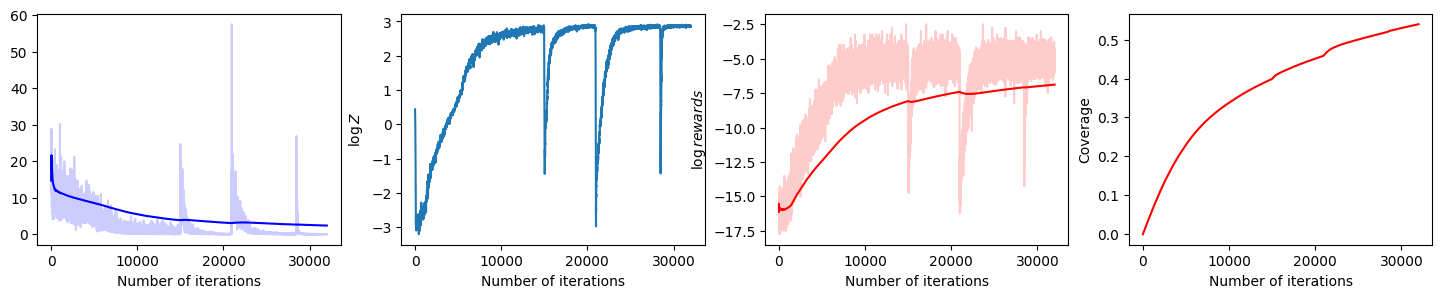

In [30]:
fig, ax = plt.subplots(1,4,figsize=(18,3))
ax[0].plot(tb_losses, alpha=0.2, color="blue")
ax[0].plot(running_average(tb_losses), color="blue")
ax[0].set_xlabel("Number of iterations")
ax[1].set_ylabel("TB loss")

ax[1].plot(logZs)
ax[1].set_ylabel("$\log Z$")
ax[1].set_xlabel("Number of iterations")

ax[2].plot(logrewards, alpha=0.2, color="red")
ax[2].plot(running_average(logrewards), color="red")
ax[2].set_ylabel("$\log rewards$")
ax[2].set_xlabel("Number of iterations")

ax[3].plot(coverage, alpha=1, color="red")
# ax[2].plot(running_average(logrewards), color="red")
ax[3].set_ylabel("Coverage")
ax[3].set_xlabel("Number of iterations")

plt.show()